# Time-series models
## Probabilistic time-series model

Given a series of observations $\{x_t, t=1,2,...,T\}$ the objective is to infer the random variables $X_t$ which might have generated those observations by specifying their distributions.  A time-series model is a specification of all the joint distributions:


$$
P(X_t\leq x_t, t=1..T).
$$

Considering an infinite time-series $X_t$ for unlimied $t$ (a stochastic process) the modelling is to specify all the joint distributions for all finite $n$:

$$
P(X_t\leq x_t, t=1..n)
$$


### Below we describe some commonly used time-series models, starting with the most basic ones.

### 1. IID and white noise


__Independent Identically Distributed (IID)__:

IID data are randomn variables that are independent from each other and drawn from the same distribution. In the context of time series, IID data has no record of time. Order is irrelevant as any given variable can be assumed to have been drawn at any point in time.

__White Noise__: 

White Noise is a stochastic process whose random variables have constant mean, constant variance and zero autocorrelation. White noise defines a process whose randomn variables are typically (but not necessarily) IID - a subtlty but worth noting\* .White noise processes whose random variables are associated with the same distribution and with those whose uncorrelateness imply independence (such as normal, binary, etc.) generate IID data.

The IID time-series are not the most interesting ones in and of themselves, but they serve as building blocks for the time-series models. Namely, an ideal time-series model should describe the given time-series up to an IID component, representing a fundamentally unpredictable part. E.g. white noise.\**

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

\* While IID data is entirely time-invariant, mutual independence or even identicallity is not a condition for white noise. IID data is unpinned from space, time or any set of points indexed by potentially different probablity distributions.

\*\* E.g., a model $X_t = q\cdot t + N(0,\sigma^2)$ would represent a linear trend with white noise random fluctuations. The following model represents a trend with a seasonal component and white noise $X_t = q\cdot t + w\cdot \sin(k \pi t) + N(0,\sigma^2)$

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg


# suppress warning
import warnings
warnings.filterwarnings('ignore')

# suppress warning
!pip install statsmodels.tsa
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss#,range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
%matplotlib inline

ERROR: Could not find a version that satisfies the requirement statsmodels.tsa (from versions: none)
ERROR: No matching distribution found for statsmodels.tsa


ImportError: ignored

In [ ]:
plt.rcParams.update({'figure.figsize':(10,5)})

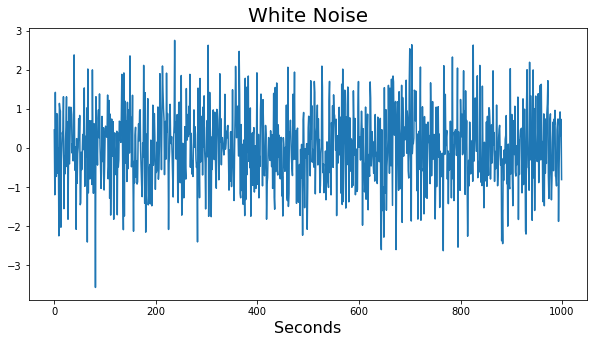

In [ ]:
#generate a white noise time-series
np.random.seed(1234)

nsteps = 1000
noise = np.random.normal(0,1,size=nsteps)

plt.plot(noise)
plt.title('White Noise', fontsize=20)
plt.xlabel('Seconds', fontsize=16)
plt.show();

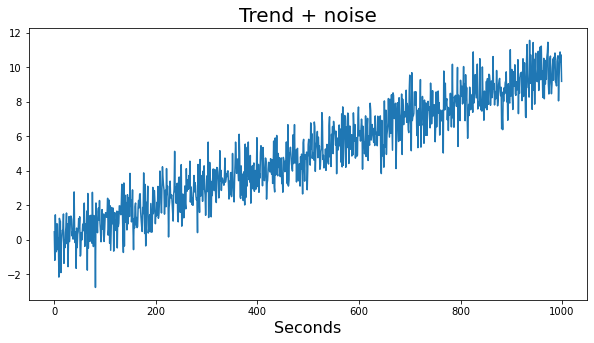

In [ ]:
#trend plus noise
t = np.arange(nsteps)
plt.plot(0.01 * t + noise)
plt.title('Trend + noise', fontsize=20)
plt.xlabel('Seconds', fontsize=16)
plt.show();

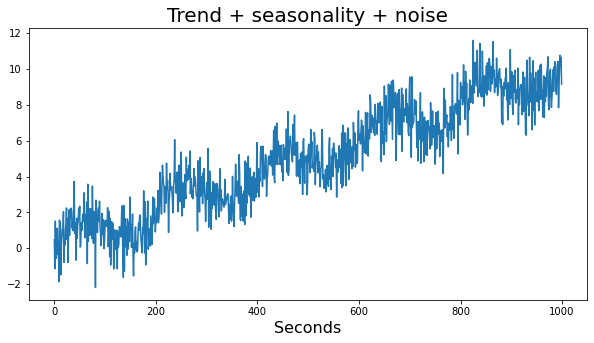

In [ ]:
#trend+seasonality+noise
t = np.arange(nsteps)
plt.plot(0.01 * t + np.sin(np.pi*t*0.01) + noise)
plt.title('Trend + seasonality + noise', fontsize=20)
plt.xlabel('Seconds', fontsize=16)
plt.show();

### 2. Random walk
Random walk process is the time-series (stochastic process) adding a random step at each moment of time, i.e. an accumulation of IID. Namely, the random walk could be represented as 
$$
X_t=X_{t-1}+Y_t
$$
where $Y_t$ is IID. $Y_t$ and $X_t$ could be discrete or continous real-valued; can be also multi-dimensional. Imagine a company earning or loosing a random amount of money during each business day. Then its total earnings could be described as a random walk process.

An exponent of the random walk process corresponds to a multiplicative random walk model
$$
X_t=X_{t-1}*Y_t
$$
(imagine a company earning or losing a random percentage of the capital each day).

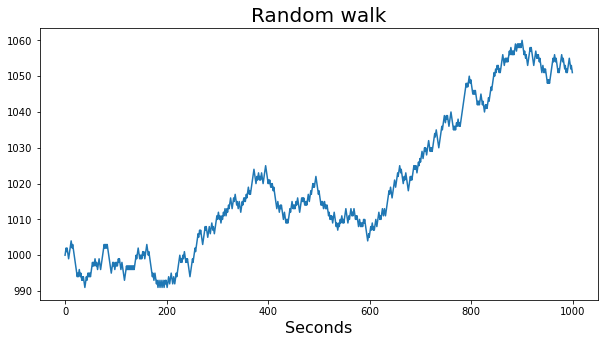

In [ ]:
# Simple Application 1: A Random Walk.

# Set an arbitrary starting point and iterate the system using a simple Markov process.
# Each second, this process can move up 1 or it can move down, which it does at random.
# Pr(up) = Pr(down) = 0.5.

# pos is starting position.
# draws are random integers, {0, 1}.
# step is -1 if random draw is 0 and +1 if random draw is 1.
# walk is the vector containing each step.

np.random.seed(1234)

pos = 1000  
walk = [pos] # walk is the array that tracks the random path
nsteps = 1000 # establishs number of random steps
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 # Bernoulli draw to step "up" or "down"
    pos += step
    walk.append(pos)

plt.plot(walk[0:1000])
plt.title('Random walk', fontsize=20)
plt.xlabel('Seconds', fontsize=16)
plt.show();

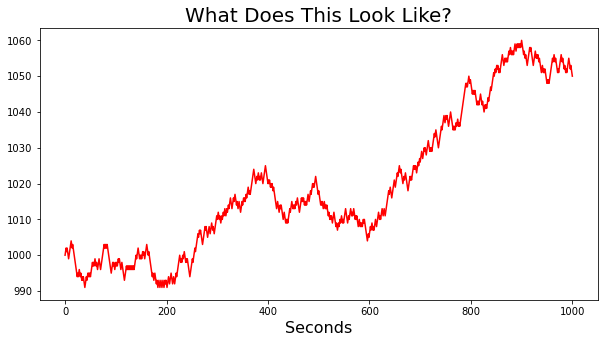

In [ ]:
plt.plot(walk[0:1800], 'r')
plt.title("What Does This Look Like?", fontsize=20)
plt.xlabel('Seconds', fontsize=16)
plt.show();

In [ ]:
import quandl
import nasdaqdatalink

In [ ]:
#get prices of Apple stock
quandl.ApiConfig.api_key = ("tzyRaxuxXa5-3guqVEkW")
aapl_all=quandl.get("WIKI/AAPL",start_date="2011-1-1", end_date="2013-1-1")
aapl_all.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2011-01-03,325.6400,330.26,324.8365,329.57,15897800.0,0.0,1.0,41.849279,42.443013,41.746018,42.354338,111284600.0
2011-01-04,332.4400,332.50,328.1500,331.29,11038600.0,0.0,1.0,42.723173,42.730884,42.171849,42.575382,77270200.0
2011-01-05,329.5500,334.34,329.5000,334.00,9125700.0,0.0,1.0,42.351768,42.967350,42.345342,42.923655,63879900.0
2011-01-06,334.7194,335.25,332.9000,333.73,10729600.0,0.0,1.0,43.016108,43.084298,42.782290,42.888956,75107200.0
2011-01-07,333.9900,336.35,331.9000,336.12,11140400.0,0.0,1.0,42.922370,43.225663,42.653776,43.196105,77982800.0


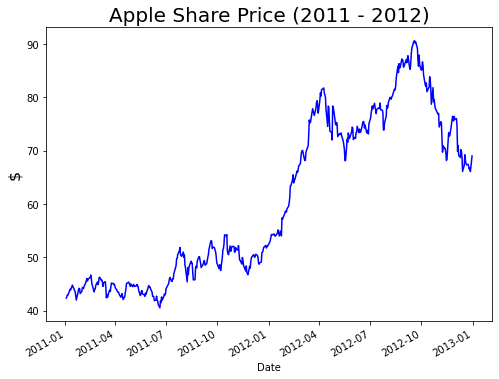

In [ ]:
aapl = aapl_all['Adj. Close']
plt.figure(figsize = (8, 6))
aapl.plot(color = 'blue')
plt.title('Apple Share Price (2011 - 2012)', fontsize=20)
plt.ylabel('$', fontsize=16)
plt.show();

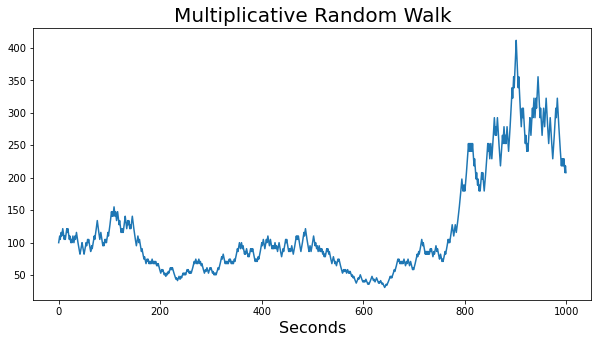

In [ ]:
#multiplicative random walk
np.random.seed(12)

pos = 100  
walk = [pos] # walk is the array that tracks the random path
nsteps = 10000 # establishs number of random steps
for i in range(nsteps):
    step = 1.05 if np.random.randint(0, 2) else 1/1.05 # Bernoulli draw to step "up" or "down"
    pos *= step
    walk.append(pos)

plt.plot(walk[0:1000])
plt.title('Multiplicative Random Walk', fontsize=20)
plt.xlabel('Seconds', fontsize=16)
plt.show();

**Example** (Gambler ruin problem, in economic formulation). The company has a starting capital of $\$$100k. At each business day it either makes $\$$1k or loses $\$$1k. It's objective is to double the capital. What are the chances of apparently reaching this goal earlier than going broke (i.e. losing all the money)?

This is a random walk process $X_t = X_{t-1}+Y_t$ where $X_t$ is the capital after $t$ days and $Y_t$ is a Bernoilli random variable representing a daily gain/loss. The problem could be solved using Markov process framework https://randomdeterminism.wordpress.com/2010/07/07/gamblers-ruin/ based on recurrent formulas for 
$P(n,N)$ (i.e. the probability of reaching N from initial capital n before reaching 0) expressed as
$$
P(n,N)=\frac{P(n-1,N)}{2}+\frac{P(n+1,N)}{2},
$$
noticing that $P(n,N)=n/N$ satisfies the equation above and proving that this solution is unique. This way $P(100,200)=100/200=1/2$.

The same could be proved using a concept of a Martingale process https://randomdeterminism.wordpress.com/2010/07/09/gamblers-ruin-2/, https://en.wikipedia.org/wiki/Martingale_(probability_theory) which states that $E[X_t]=const=E[X_{final}]$ where $X_{final}$ is the final capital at the end of the process (either reaching the goal of $\$$200k or reaching zero, i.e. going broke). Since $X_0=100$, then $100 = E[X_{final}] = 0\cdot P(X_{final}=0)+200\cdot P(X_{final}=200)$, consequently $P(X_{final}=200)=1/2$. 

Generalizing the problem for an arbitrary objective $N$ and starting capital $n$ the last equation is $n = N\cdot P(X_{final}=N)$, i.e. $P(X_{final}=N)=n/N$. The theory of Martingale processes also allows to find the average number of days before the process finalizes from the equation $E[X_{final}^2 - t_{final}]=const=E[X_t^2 - t]=E[X_0^2]-0=n^2$, i.e. $E[t_{final}]=N^2*(n/N)-n^2=n(N-n)$ or in our case of $n=100, N=200$ this gives $E[t_{final}]=10000$. 

Of course in each particular case it can happen either sooner or later than that. Below are two examples

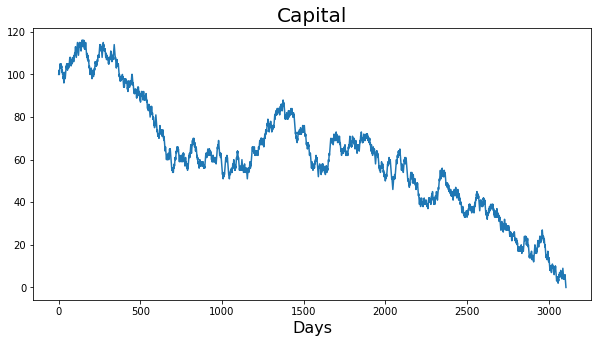

Finalized in 3107 days


In [ ]:
np.random.seed(1)

pos = 100  
walk = [pos] # walk is the array that tracks the random path
nsteps = 20000 # establishs number of random steps
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 # Bernoulli draw to step "up" or "down"
    pos += step
    walk.append(pos)
    if pos == 0 or pos == 200:
        break   

plt.plot(walk)
plt.title('Capital', fontsize=20)
plt.xlabel('Days', fontsize=16)
plt.show();
print('Finalized in {} days'.format(len(walk)))

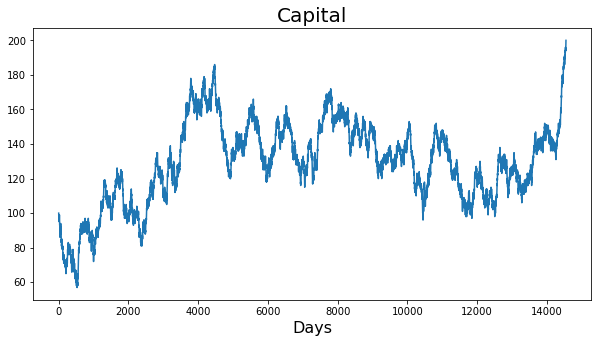

Finalized in 14547 days


In [ ]:
np.random.seed(9)

pos = 100  
walk = [pos] # walk is the array that tracks the random path
nsteps = 20000 # establishs number of random steps
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 # Bernoulli draw to step "up" or "down"
    pos += step
    walk.append(pos)
    if pos == 0 or pos == 200:
        break   

plt.plot(walk)
plt.title('Capital', fontsize=20)
plt.xlabel('Days', fontsize=16)
plt.show();
print('Finalized in {} days'.format(len(walk)))

**2D random walk example**
A Drunken Sailor on a Mountaintop (2d random walk time-series)

A sailor stands in the center of a square 200x200 mountain top. At each moment of time sailor does a random step in either of the four directions


In [ ]:
np.random.seed(1)
edge = 50
nsteps = 20000

xy = [np.array([0, 0])] #initial position
steps = np.array([[-1,0],[1,0],[0,-1],[0,1]]) 
for i in range(nsteps):
    xy += [xy[-1] + steps[np.random.choice(4),:]] #make a step in random direction
    if np.max(np.abs(xy)) > edge:
        print("Sailor fell off the moutain at coordinates", xy[-1], "on step", i)
        break

Sailor fell off the moutain at coordinates [-26 -51] on step 2964


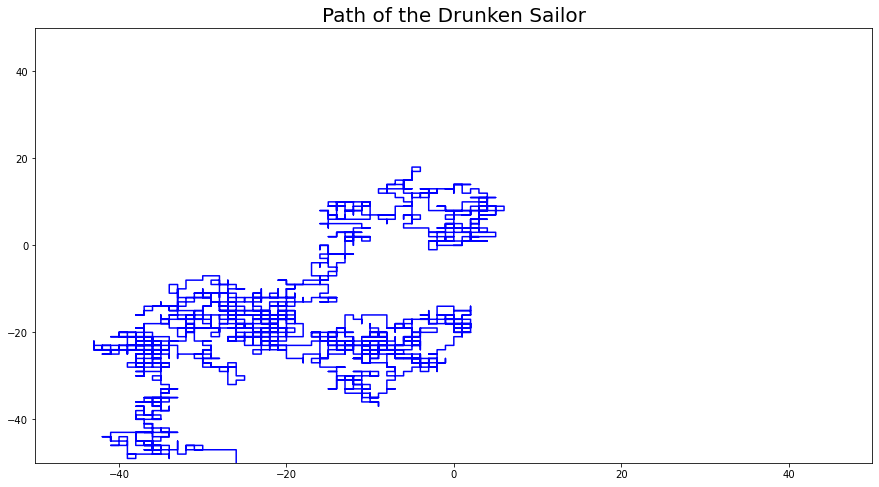

In [ ]:
plt.rcParams.update({'figure.figsize':(15,8)})
plt.plot(np.array(xy)[:,0], np.array(xy)[:,1], 'b')
plt.title("Path of the Drunken Sailor", fontsize=20)
plt.xlim(-edge, edge)
plt.ylim(-edge, edge)
plt.show();

# Stationarity and autocorrelation

__Autocorrelation__ : 

Despite the minimal dependencies found in certain model forms such as Random Walks, leveraging time series correlation with past values are at the heart of time series predictive modeling. This __autcorrelation__ function can be described as:

$$
\rho(\tau)=corr(X_t,X_{t+\tau})=\frac{Cov(X_t,X_{t+\tau})}{\sqrt{Var[X_t]Var[X_{t+\tau}]}}
$$

__Stationary process__ :

To further maximize the potential for quality predictions, time series models require correlation stucture to exhibit consistency. A Stationary process satisifes this need: It is a process whose statistical properties do not change with time. In its strictest form ("__Strong Sense Stationarity__"), all joint distributions do not depend on the specific choice of the initial moment of time $t_1$ or $t_2$:

$
P(X_{t_1+\tau}\leq x_\tau, \tau=0..n)=P(X_{t_2+\tau}\leq x_\tau, \tau=0..n)
$

A more practical process is one whose mean is constant and autocorrelation is stable for a given lag across time (known as __"Wide Sense Stationary"__ or "Weak Sense Stationary"):

Constant Mean:  
$
E[X_t]=\mu
$

Lag-only dependent Cov/Corr:  
$
Cov(X_{t_1},X_{t_2})
$
in t_1 and t_2 are finite and depend only on their lag $t_2-t_1$ (and not on the spefic moment $t_1$ or $t_2$):

$
Cov(X_{t},X_{t+\tau})=Cov(X_{t^*},X_{t^*+\tau})=\gamma(\tau),
$
where $\gamma$ is a certain symmetric non-negative-valued function of a time lag $\tau$: $\gamma(-\tau)=\gamma(\tau)>0.$

It further follows that:

$
Var[X_t]=\gamma(0)=const.
$

So in addition to mean, variance of all variables $X_t$ is constant.

Then __autocorrelation__ function could be defined as:

$
\rho(\tau)=corr(X_t,X_{t+\tau})=\frac{Cov(X_t,X_{t+\tau})}{\sqrt{Var[X_t]Var[X_{t+\tau}]}}=\frac{\gamma(\tau)}{\gamma(0)}
$


In particular, IID is certainly stationary with 
$
\rho(\tau)=\left\{\begin{array}{c}1,\ \tau=0,\\0,\ \tau\neq 0.\end{array}\right.
$

#### Stationarity is an important concept for time-series analysis as stationary processes possess many properties useful for analysis, while for non-stationary processes the objective of the analysis is often seen to transform them to the stationary form (the "chase for stationarity").

## Which is Stationary?


![Stationarity.png](attachment:Stationarity.png)


* (a) Google stock price for 200 consecutive days; 
* (b) Daily change in the Google stock price for 200 consecutive days; 
* (c) Annual number of strikes in the US; 
* (d) Monthly sales of new one-family houses sold in the US; 
* (e) Annual price of a dozen eggs in the US (constant dollars); 
* (f) Monthly total of pigs slaughtered in Victoria, Australia; 
* (g) Annual total of lynx trapped in the McKenzie River district of north-west Canada; 
* (h) Monthly Australian beer production; 
* (i) Monthly Australian electricity production.

In [ ]:
#img = mpimg.imread('Stationarity.png')
#plt.figure(figsize = (30,15))
#fig = plt.imshow(img)
#fig.axes.get_xaxis().set_visible(False)
#fig.axes.get_yaxis().set_visible(False)
#plt.axis('off')
#plt.show();

In [ ]:
pd.DataFrame({'Today':aapl,'Yesterday':aapl.shift(1)}).dropna().corr() #correlation is strong but will decrease with lag

,Today,Yesterday
Today,1.000000,0.997342
Yesterday,0.997342,1.000000


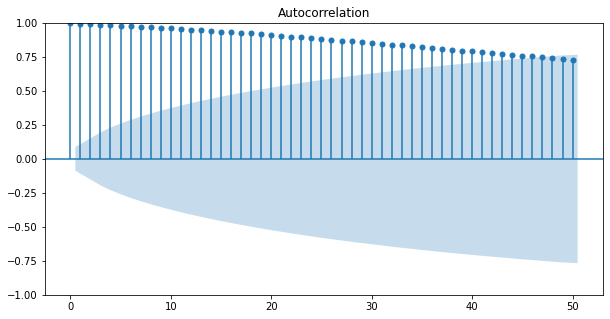

In [ ]:
#autocorrelation in apple stock prices
plt.rcParams.update({'figure.figsize':(10,5)})
plot_acf(aapl, lags=50);

In [ ]:
#stock prices have obvious autocorrelation but the daily changes do not
appl_ret=np.log(aapl)-np.log(aapl.shift(1))

In [ ]:
appl_ret.shift(1).head()

Date
2011-01-03         NaN
2011-01-04         NaN
2011-01-05    0.005205
2011-01-06    0.008147
2011-01-07   -0.000809
Name: Adj. Close, dtype: float64

In [ ]:
pd.DataFrame({'Returns':appl_ret,'Lag returns':appl_ret.shift(1)}).dropna().corr()

,Returns,Lag returns
Returns,1.000000,-0.001785
Lag returns,-0.001785,1.000000


In [ ]:
appl_ret.head()

Date
2011-01-03         NaN
2011-01-04    0.005205
2011-01-05    0.008147
2011-01-06   -0.000809
2011-01-07    0.007136
Name: Adj. Close, dtype: float64

Ljung–Box:
      lb_stat  lb_pvalue
1    0.001583   0.968265
2    0.142561   0.931201
3    1.866376   0.600598
4    3.180282   0.528122
5    3.757043   0.584899
6    5.540882   0.476529
7   13.140429   0.068760
8   13.149586   0.106805
9   13.154376   0.155744
10  19.317603   0.036409


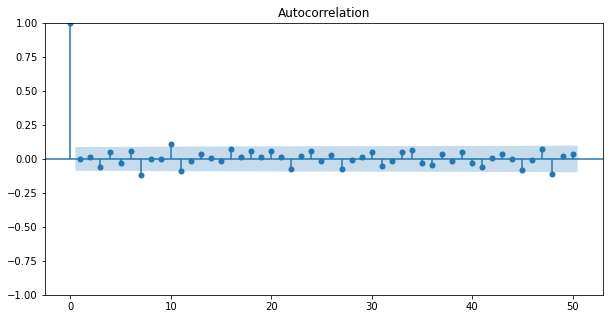

In [ ]:
plot_acf(appl_ret.dropna(), lags=50);
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(appl_ret.dropna()))

## Advanced time-series models 

### 1. Moving average process MA(p)
A simple generalization of white noise process is considering it's weighted moving averages
$$
X_t = Y_t+\sum_{j=1}^p \theta_j Y_{t-j}
$$
where $p$ is called an order of the MA process.

Or admitting non-zero mean of the series one may add a constant term to this definition:
$$
X_t = c + Y_t+\sum_{j=1}^p \theta_j Y_{t-j}
$$

**Example.** A real-world example of a MA process (which are somehow surprisingly hard to find in the textbooks) could be the current number of passengers in the airport on a given hourly observation in the assumption that the number of incoming passengers at each hour are indepenent normally distributed random variables $P_t = \mu + Y_t$, where $Y_t\sim N(0,\sigma^2)$ (ignoring a minor probability of getting a negative value assuming relatively small $\sigma/\mu$) and assuming that $1/3$ of the arriving passengers leave airport one hour upon arrival, another $1/3$ - two hours upon arrival, and the rest - three hours upon arrival. Then the total number of passengers present in the airport on a given hour $t$
$$
X_t = P_t + P_{t-1}/3 + P_{t-2}/3 + P_{t-3}/3 = 2\mu + Y_t + Y_{t-1}/3 + Y_{t-2}/3 + Y_{t-3}/3
$$
would be a MA(3) process. 

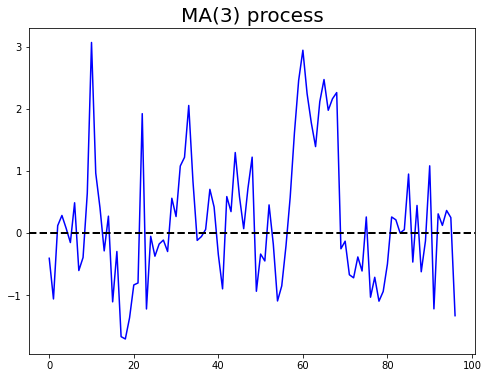

In [ ]:
plt.rcParams.update({'figure.figsize':(10,5)})
T = 100
p=3
#generating and visualizing MA(3) process
theta=[1, 0.5, 0.3, 0.2]
np.random.seed(2014)
y=np.random.normal(0, 1, T)
x=0
for k in range(0,p+1):
    x=x+theta[k]*y[range(p-k,T-k)]
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
#plt.ylim(-4, 4)
plt.title('MA(3) process', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.show();

#### while also sort of randomly fluctuating around zero, it has somewhat more consistent ups and downs, which tend to last for some time rather than alternate at every step like in case of while noise

### 2. Autoregressive Processes AR(q)
This process would model the rule that "Today is mostly yesterday plus a little noise."
We can write the AR(1) process as follows: 
$$
X_t = \rho X_{t-1} + Y_t
$$ 
In case $\rho=1$ this is a random walk process. Or with the constant term accounting for a possible non-zero average:
$$
X_t = c + \rho X_{t-1} + Y_t
$$ 

**Example.** To illustrate AR(1) we can also use the above airport passengers example, but replacing a passenger leaving strategy with a more uniform rule: every passenger currently present at the airport has a $1/3$ chance of leaving it on the next hour. Then the number of passengers on a given hour
$$
X_t = \left(1-\frac{1}{3}\right) X_{t-1} + P_t = \frac{2}{3} X_{t-1} + Y_t + \mu,
$$
i.e. follow an AR(1) process.

For $|\rho|<1$ this process is stationary and

$\displaystyle {Cov(X_t, X_{t-1})= E(X_t \cdot X_{t-1}) = \frac{\rho}{1-\rho^2}}$

Indeed, for any $k$,

$\displaystyle {Cov(X_t, X_{t-k})= \frac{\rho^k}{1-\rho^2}}$

More importantly, since correlation is defined as covariance divided by variance, for any AR(1) process, $y_t$, 
the "autocorrelation" function is simply:

$\displaystyle {Corr(X_t, X_{t-k})= \rho^k}$

Here, autocorrelation simply means "correlated with itself through time".

Therefore, in summary, the AR(1) process, $X_t$, has the following characteristics (in case $c=0$):

1. Zero mean.
2. Finite variance.
3. Autocorrelation function that decays geometrically, $\rho^k$, over $k$ periods.  Note that for $k=0$, correlation is 1 (as it should be).

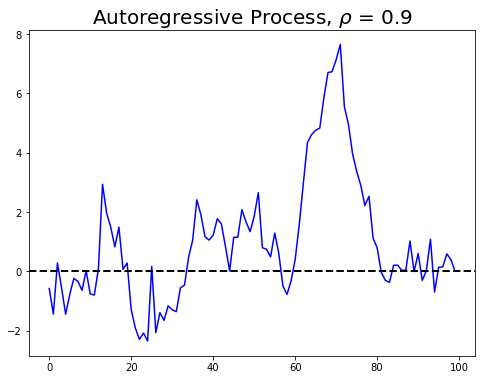

In [ ]:
np.random.seed(2014)
#generating and visualizing AR(1) process
T = 99
rho = 0.9
x = np.zeros(T+1)

x[0] = np.random.normal(0, 1)

for t in range(1, T):
    x[t] = rho * x[t-1] + np.random.normal(0, 1)

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.show();

Now further generalizing to a $q$ degree process AR(q):
$$
X_t = \sum_{j=1}^q \rho_j X_{t-j} + Y_t.
$$

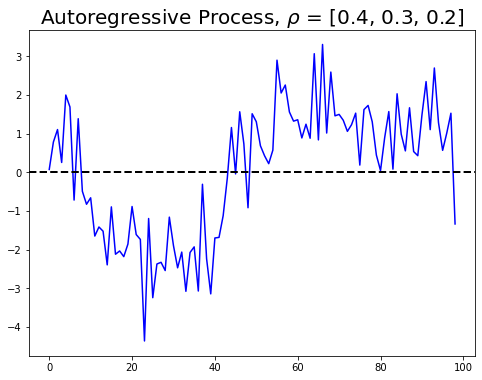

In [ ]:
np.random.seed(2011)
#generating and visualizing AR(3) process
T = 99
rho = [0.4, 0.3, 0.2]
x = np.zeros(T+1)

x = np.random.normal(0, 1, 3)

for t in range(3, T):
    x=np.append( x, rho [0] * x[t-1] + rho [1] * x[t-2] + rho [2] * x[t-3] + np.random.normal(0, 1))

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.show()

So AR process can generate much longer below-average and above-average segments and even smth like short-term trends which however do not last. But remember that this is still a random process, so any visible patterns are just random emergences.

### 4.3. ARMA(p,q)
Combining both MA and AR terms together
$$
X_t = Y_t+\sum_{j=1}^p \theta_j Y_{t-j}+\sum_{j=1}^q \rho_j X_{t-j}.
$$

In [ ]:
"""
Random generation of Gaussian ARMA(p,q) time series from http://stats.stackexchange.com/questions/37437/random-generation-of-arma2-2-gaussian-time-series

INPUTS

phi:      An array of length p with the AR coefficients (the AR part of 
          the ARMA model).

theta:    An array of length q with the MA coefficients (the MA part of 
          the ARMA model).

sigma:    Standard deviaton of the Gaussian noise.

n:        Length of the returned time-series.

burnin:   Number of datapoints that are going to be discarded (the higher 
          the better) to avoid dependence of the ARMA time-series on the 
          initial values.
""" 

from numpy.random import normal
from numpy import *
def ARMAgenerator(phi,theta,sigma,n,burnin=0,verbose=0):
    l=max(len(phi),len(theta))
    if(burnin==0):
        burnin=10*l # Burn-in elements!
    w=normal(0,sigma,n+burnin)
    ARMA=array([])
    s=0.0
    l=max(len(phi),len(theta))
    for i in range(n+burnin):
        if(i<l):
            ARMA=append(ARMA,w[i])
        else:
            s=0.0
            for j in range(len(phi)):
                s=s+phi[j]*ARMA[i-j-1]
            for j in range(len(theta)):
                s=s+theta[j]*w[i-j-1]
        ARMA=append(ARMA,s+w[i])
    if(verbose!=0):
        print ('Measured standard deviation: '+str(sqrt(var(w[burnin:]))))
    return ARMA[burnin:]

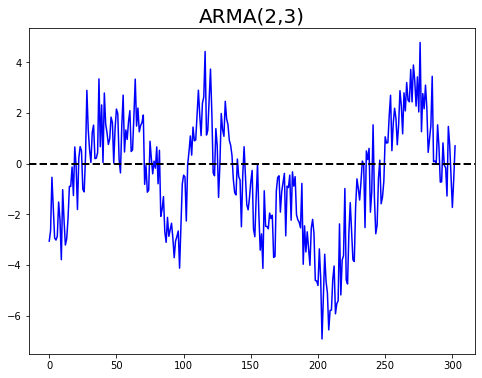

In [ ]:
random.seed(2011)
x=ARMAgenerator([0.5, 0.4],[0.4,0.3,0.2],1,300)
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
plt.title(r'ARMA(2,3)', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.show();

ARMA process can demonstrate both - short-term trends and more frequent fluctuations around them; smth resembling a trend-seasonality pattern.

### 4.4. ARIMA(p,q,d)
An even more general process, often used in practice for modeling time-series is ARIMA, being a discrete integration of ARMA. If 
$$
\nabla X_t=X_t-X_{t-1}=Y_t \sim ARMA(p,q)
$$
then process $\{X_t\}\sim ARIMA(p,q,1)$, which is basically a random wals with ARMA steps.

Similarly if 
$$
\nabla X_t\sim ARIMA(p,q,1),
$$
i.e. 
$$
\nabla^2 X_t\sim ARMA(p,q)
$$ 
then $\{X_t\}\sim ARIMA(p,q,2)$, i.e. a random walk with $ARIMA(p,q,1)$ steps. 

Finally we say $\{X_t\}\sim ARIMA(p,q,d)$ if
$$
\nabla^d X_t\sim ARMA(p,q).
$$ 

So $ARIMA(p,q,d)$ is a random walk with $ARIMA(p,q,d-1)$ steps.

Note that $AR$, $MA$ and $ARMA$ produce stationary time-series, while for $d>0$ the $ARIMA$ model is capable of prodicing non-stationary time-series as similar to the random walk processes, the parameters of $X_t$ start to depend on $X_{t-1}$. 

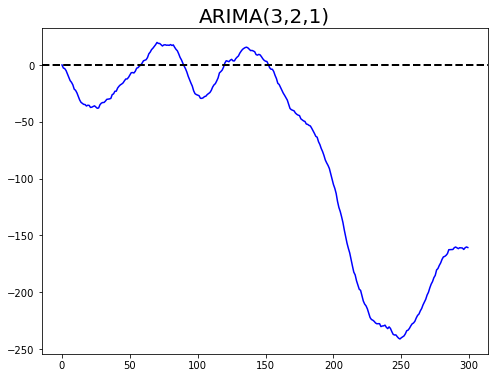

In [ ]:
T = 300
x1=[0]
for t in range(1, T):
    x1=np.append( x1, x1[t-1] + x[t])

plt.figure(figsize = (8, 6))
plt.plot(x1, 'b')
plt.title(r'ARIMA(3,2,1)', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.show();

ARIMA is capable of generating much more lasting patterns and this way is the most suitable for modeling real-world data. Most importantly, ARIMA can be used to model non-stationary time-series. But again, remember that ARIMA is a fundamentally random process, so any patterns you observe as just random emergences. Also, despite being able to demonstrate lasting local trends, overall the ARIMA model is trend-free with $E[X_t] = 0$. For modeling data with consistent trends, a combination of the functional trend and ARIMA term or applying an ARIMA model after detrending could be suggested.

Next consider using ARIMA model to fit the real data.

## ARIMA Models

To summarize, an ARIMA model is a class of statistical models for analyzing and forecasting time series data.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average(ARMA) and adds the notion of integration. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **p**: The size of the moving average window, or the number of the moving average terms, also called the order of moving average.
- **q**: The number of AR terms included in the model, also called the lag order.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

**Example** Number of users connected to the Internet through a server every minute.

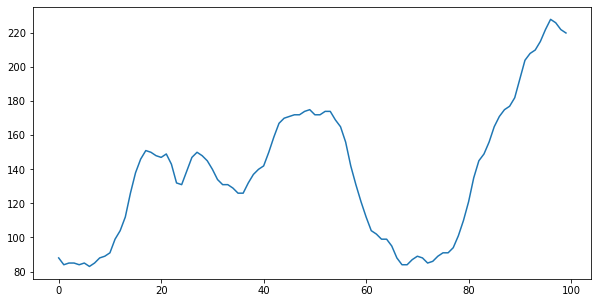

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

plt.plot(range(len(df)),df.value);


As mentioned ARIMA for $d=0$ is stationary (essentially being ARMA), while for $d>1$ it is not. So the first question to ask when fitting ARIMA is whether the time-series is stationary. Depending on that we'll need to choose $d>0$ or $d=0$. 

Introduce a statistical test of stationarity (Augmented Dickey–Fuller, see https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) below. By considering the autocorrelation values it evaluates a null hypothesis of having a unit root, while rejecting the null hypothesis would mean stationarity of the time-series. However if the null hypothesis can not be rejected, the time-series might not be stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

series=df['value']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.464240
p-value: 0.124419
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583


So having a p-value of 12.4\% we can't reject the null hypothesis, the time-series might not be stationary.

Based on the above results from adfuller test, the time-series is not stationary, so we should consider ARIMA with $d>0$, i.e. with differencing. But how should we choose the $d$?

## How to find the order of differencing (d) in ARIMA model

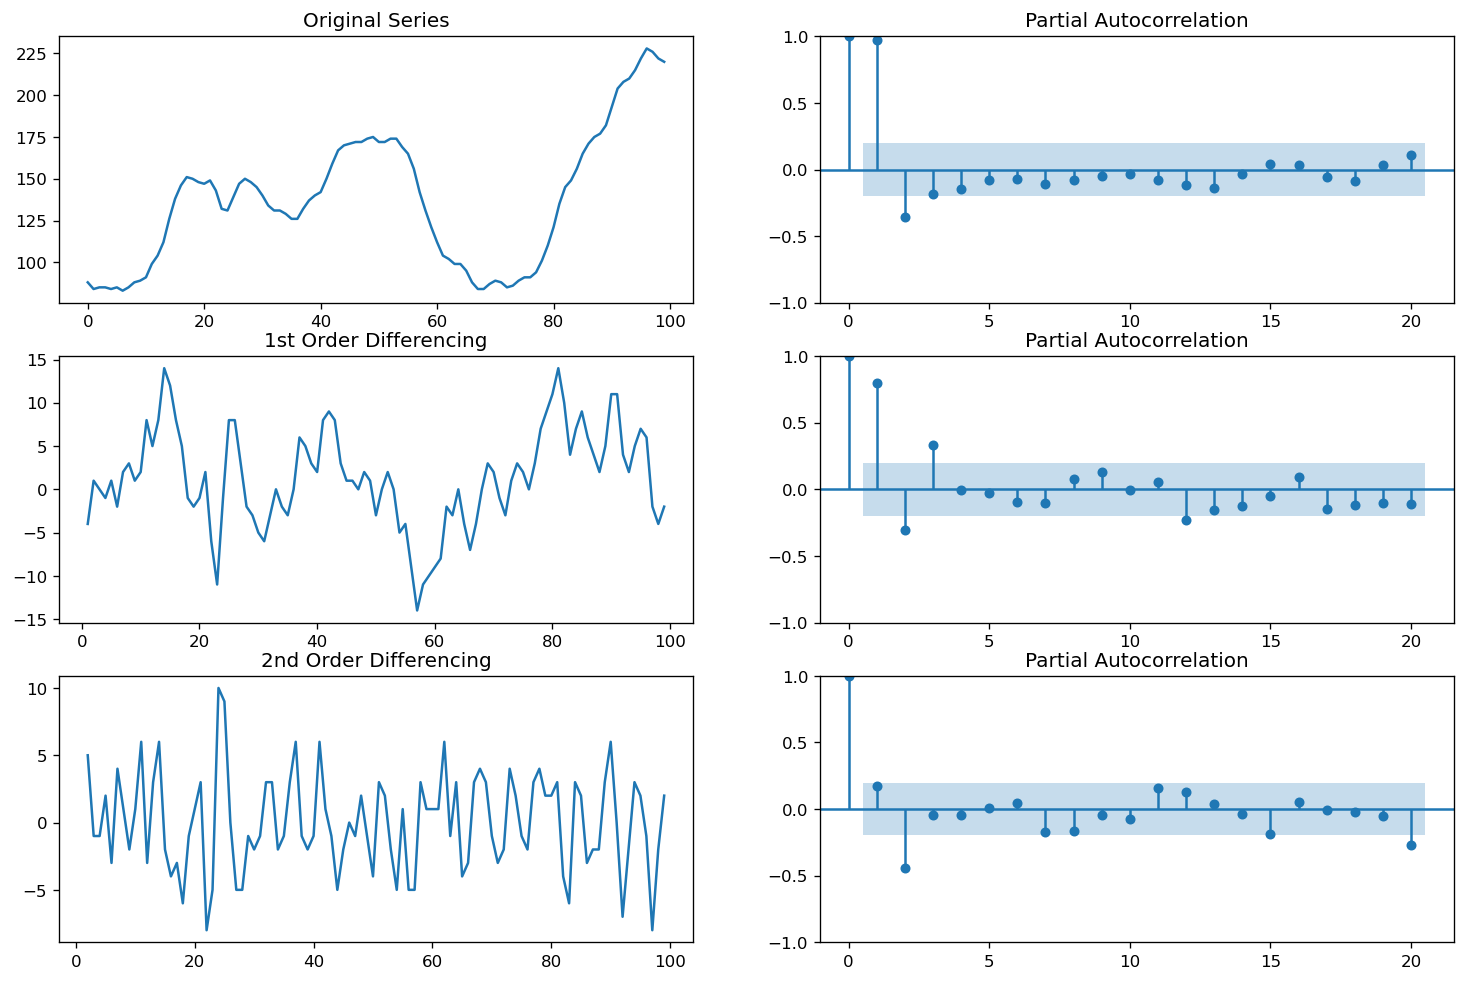

In [ ]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_pacf(df.value, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df.value.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(df.value.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')

plt.show()

Notice that on the right we are showing the PACF which is a partial auto-correlation function. Basically, it finds correlation of the residuals which remains after removing the effects which are already explained by the earlier lag(s) with the next lag value. Indeed if we know that the observations are correlated with the previous ones (lag 1) than the the observations at lag 2 are expected to have some correlation just through both being correlated with the observation at the lag 1. So for the partial ACF we account for already found correlations before we find the next lag correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

The partial autocorrelations at all lags can be computed by fitting a succession of autoregressive models with increasing numbers of lags. In particular, the partial autocorrelation at lag k is equal to the estimated AR(k) coefficient in an autoregressive model with k terms--i.e., a multiple regression model in which Y is regressed on LAG(Y,1), LAG(Y,2), etc., up to LAG(Y,k).

#### The Augmented Dickey–Fuller can clearly help find the differencing order as well.

In [ ]:
# raw
series=df['value']#.diff()
result = adfuller(series.dropna())
print('raw observations:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])


# first order differencing
series=df['value'].diff()
result = adfuller(series.dropna())
print('\n1st order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

# second order differencing
series=df['value'].diff().diff()
result = adfuller(series.dropna())
print('\n2nd order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

raw observations:
  ADF Statistic: -2.464240
  p-value: 0.124419

1st order differencing:
  ADF Statistic: -2.722238
  p-value: 0.070268

2nd order differencing:
  ADF Statistic: -9.929762
  p-value: 0.000000


Dataset is stationary after differenced once, $alpha=0.1$. After differecing twice, autocorrelations are all small and patternless, and drop to insignificant area too quick, then the series does not need a higher order of differencing.

### *********** #####
## An example of __Stationary__ dataset: bay area rapid transit daily passenger volume from 2017-2019

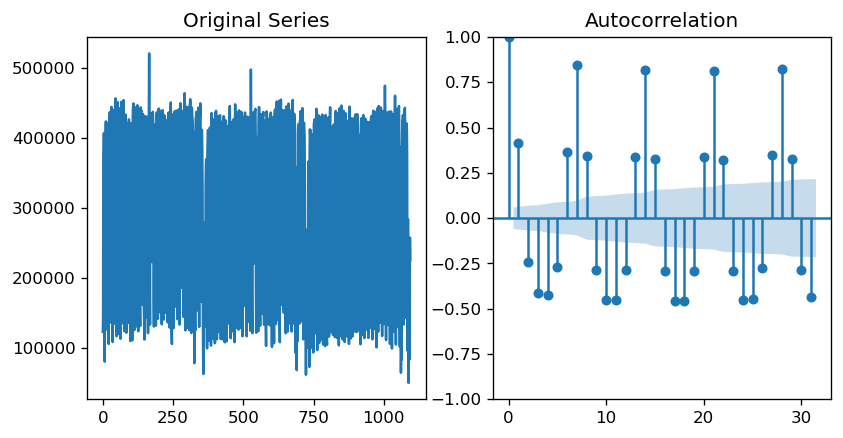

ADF Statistic: -5.734629
p-value: 0.000001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [ ]:
bart = pd.read_csv('bart_s2.csv')

fig, axes = plt.subplots(1, 2,figsize=(8,4))
axes[0].plot(bart.passenger)
axes[0].set_title('Original Series')
plot_acf(bart.passenger, ax=axes[1])
plt.show()

series=bart['passenger']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

## Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.
* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.
* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

More detail on:

https://people.duke.edu/~rnau/411arim3.htm

https://people.duke.edu/~rnau/arimrule.htm

## How to find the AR term (q)
Determine the AR terms by inspecting the Partial Autocorrelation (PACF) plot. By mere inspection of the PACF you can determine how many AR terms you need to use to explain the autocorrelation pattern in a time series: if the partial autocorrelation is significant at lag k and not significant at any higher order lags--i.e., if the PACF "cuts off" at lag k--then this suggests that you should try fitting an autoregressive model of order k

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. We take the order of AR term to be equal to as many lags that cross the significance area in the PACF plot or until a shart drop-off. This likely suggests AR(1). On the other hand in the PACF plot, lags 2 and 3 are also well above/below the blue area of values acheivable by random, so we can try Q=3 as well.

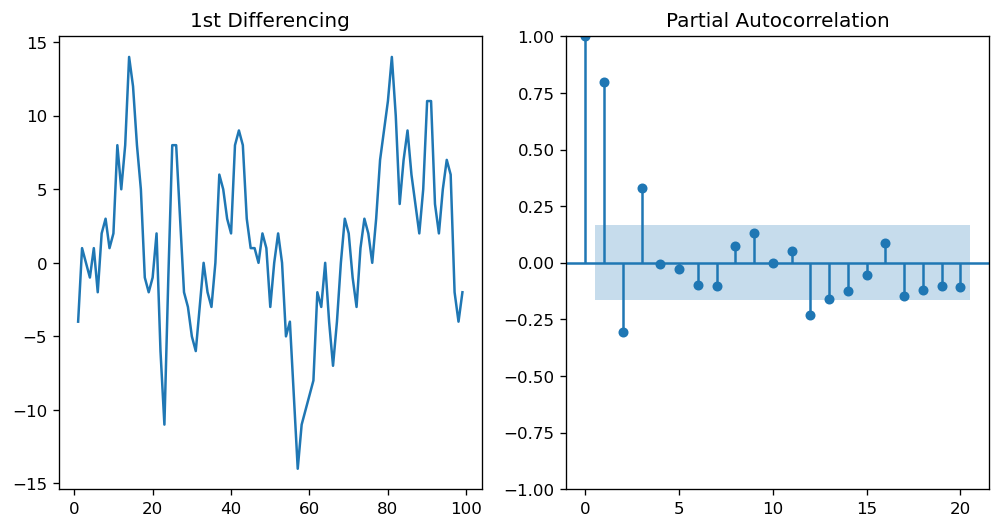

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(df.value.diff())
axes[0].set_title('1st Differencing')
# axes[1].set_ylim(0,1)
plot_pacf(df.value.diff().dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations

plt.show()

## How to find the MA term (p)

ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

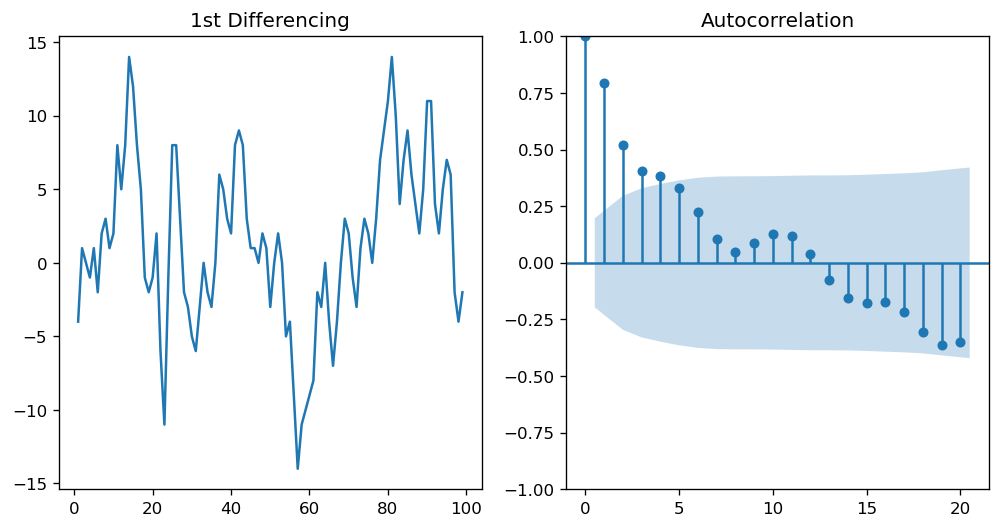

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

We have a sharp cutoff in PACF plot, and a somewhat noticeable although not as clear drop in the ACF plot after the first lag. Several further lags also have the autocorrelation within the significance area (above the blue area, indicating the values possible by random), however they happen after a drop off; besides including multiple MA terms along with multiple AR terms is not advisable as their effect might overlap. So we suggest $P=1$ in this case. 

Thus, our parameter choice for the model would be **Q=3, P=1**, although one could also try smaller **Q** and/or larger $P$.


Alternative approach for selecting the hyperparameters of ARIMA would be to evaluate the goodness of fit corrected by the model complexity, e.g. by using AIC (Akaike Information Criterion).

A useful discussion on tuning the ARIMA parameters could be found on https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

The statsmodels library provides the capability to fit an ARIMA model with the given $p,q,d$ parameters.

An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling ARIMA() and passing in the p, d, and q parameters.
The model is learned over the training data by calling the fit() function.
Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.
Let’s start off with something simple. We will fit an ARIMA model to the entire dataset and review the residual errors.

First, we fit an ARIMA(1,1,3) model. This sets the lag value to 3 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 1.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

### The Ljung–Box test can detect autocorrelations for up to 10 lags - a good way to tell how well close you are to achieving white noise.

## Forecasting

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   90
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -227.139
Date:                Tue, 15 Feb 2022   AIC                            464.277
Time:                        19:35:24   BIC                            476.721
Sample:                             0   HQIC                           469.293
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9853      0.365      2.699      0.007       0.270       1.701
ar.L2         -0.4470      0.400     -1.117      0.264      -1.231       0.337
ar.L3          0.2588      0.156      1.656      0.0

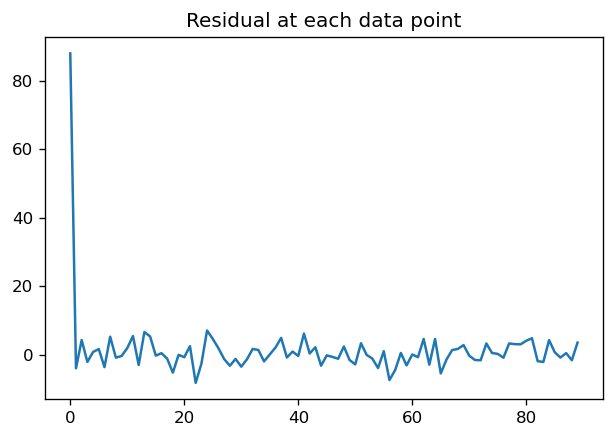

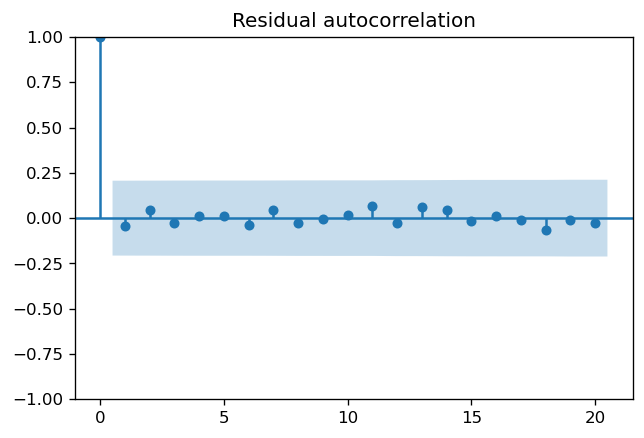

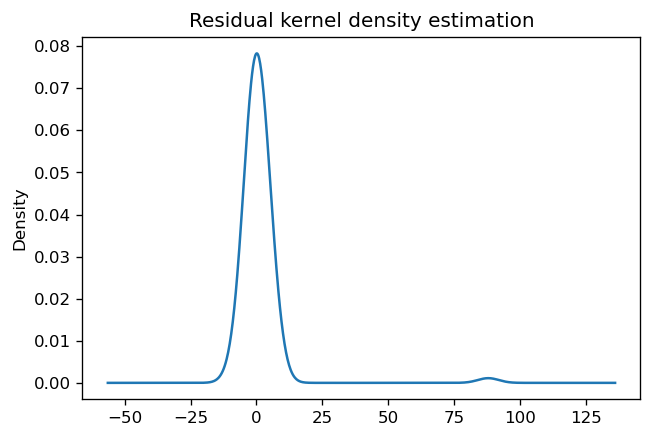

               0
count  90.000000
mean    1.211665
std     9.755679
min    -8.263289
25%    -1.580329
50%    -0.022598
75%     2.438547
max    88.000000
p value is  2.6481958619626075e-39
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
     lb_stat  lb_pvalue
1   0.195310   0.658533
2   0.371409   0.830519
3   0.433501   0.933238
4   0.441490   0.978941
5   0.457500   0.993597
6   0.610878   0.996216
7   0.836237   0.997056
8   0.895958   0.998824
9   0.900642   0.999634
10  0.933252   0.999875


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

P=1
D=1
Q=3

# fit model
N=90   
series = df['value']#.values

#model = sm.tsa.SARIMAX(series[:N], order=(Q,D,P))
model = sm.tsa.ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

#### First, we get a line plot of the residual errors, suggesting that the trend is likely already taken care of in the ARIMA model. Next, we get a density plot of the residual error values. Finally distribution of the residual errors is displayed.

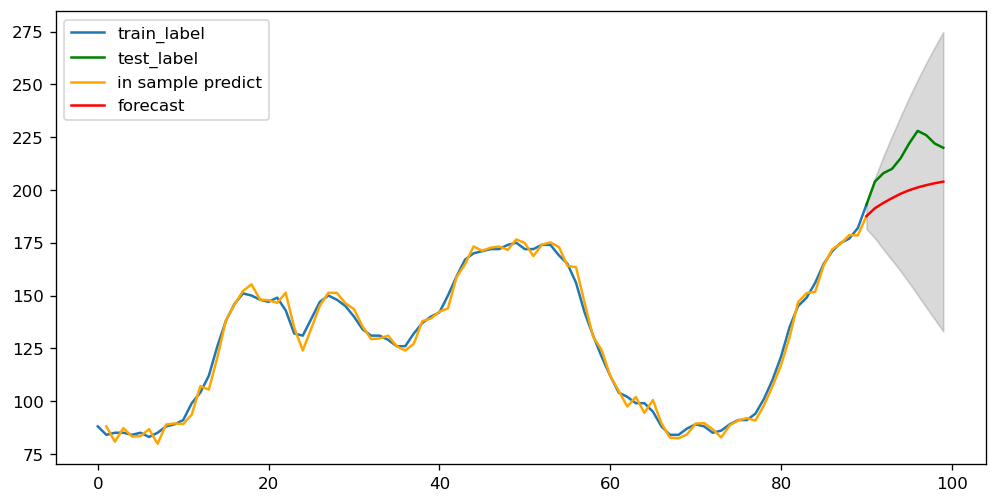

In [ ]:
# Forecast

fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(df.index[:N+1],series[:N+1],label='train_label') # train
ax.plot(df.index[N:],series[N:],color='green',label='test_label') # test
ax.plot(df.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(df.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')

A feature of ARIMA is the forecast based on historical data. In the model training part, the model keeps ingesting correct historical information. As a result, even the prediction deviates from reality a lot on day x, on day x+1, the model will get the accurate historical data of day x, making sure that the model will not make a new prediction based on the wrong previous prediction (check the red rectangular in the figure above). But in the out-of-sample forecast part, the model predicts based on the previous prediction, which might cause the model to move in the wrong direction. Hence, the ARIMA model might not be the right choice for long-term prediction.

## Trend forecast on the same dataset

In [ ]:
# train
X = pd.DataFrame(range(N),columns=['day'])
X = sm.add_constant(X)
lm=sm.OLS(df.value[:N],X).fit()
insample = lm.predict(X)
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.559
Date:                Tue, 15 Feb 2022   Prob (F-statistic):              0.113
Time:                        19:35:30   Log-Likelihood:                -437.36
No. Observations:                  90   AIC:                             878.7
Df Residuals:                      88   BIC:                             883.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        119.3302      6.598     18.086      0.0

In [ ]:
#test
X = pd.DataFrame(range(N-1,len(df)),columns=['day'])
X = sm.add_constant(X)
pred = lm.predict(X)

In [ ]:
# compare out-of-sample performance
print('ARIMA model out-of-sample MAE', mean_absolute_error(df.value[N:],fc_series))
print('trend model out-of-sample MAE', mean_absolute_error(df.value[N-1:],pred))

ARIMA model out-of-sample MAE 17.02681221555906
trend model out-of-sample MAE 73.23537461290266


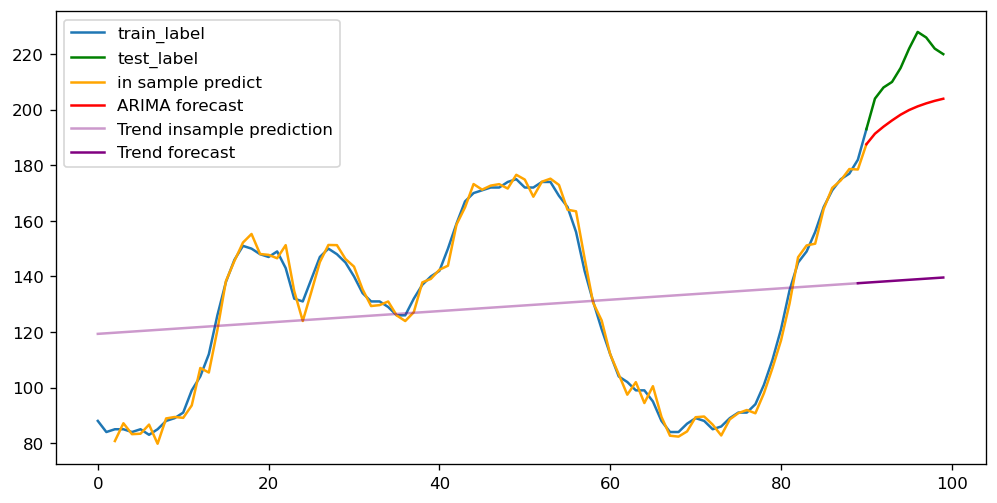

In [ ]:
plt.plot(df['value'][:N+1],label='train_label')
plt.plot(range(N,len(df)),df['value'][N:],color='green',label='test_label')
plt.plot(range(P+D,N+1),model_fit.predict(start=P+D,end=N,dynamic=False,typ='levels'),color='orange',label='in sample predict')
plt.plot(fc_series, label='ARIMA forecast', color='red')

plt.plot(insample, label='Trend insample prediction', color='purple',alpha=0.4)
plt.plot(range(N-1,len(df)),pred, label='Trend forecast', color='purple')

plt.legend(loc='upper left')

# An ARIMA-unpredictable example, Dow Jones Industrial Average

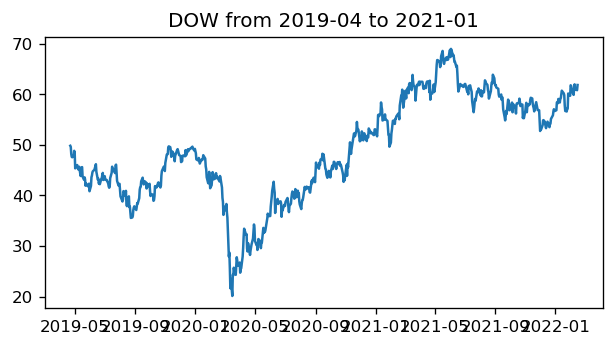

In [ ]:
import pandas_datareader.data as web
from datetime import date
plt.rcParams.update({'figure.figsize':(6,3)})
start, end = "2019-04-20", date.today()
dow = web.get_data_yahoo("DOW", start=start, end=end)['Adj Close']
plt.plot(dow)
plt.title('DOW from 2019-04 to 2021-01')
plt.show();

In [ ]:
print('raw series')
result = adfuller(dow)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('1st order differencing')
result = adfuller(dow.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

raw series
ADF Statistic: -1.194310
p-value: 0.676039
1st order differencing
ADF Statistic: -27.128840
p-value: 0.000000


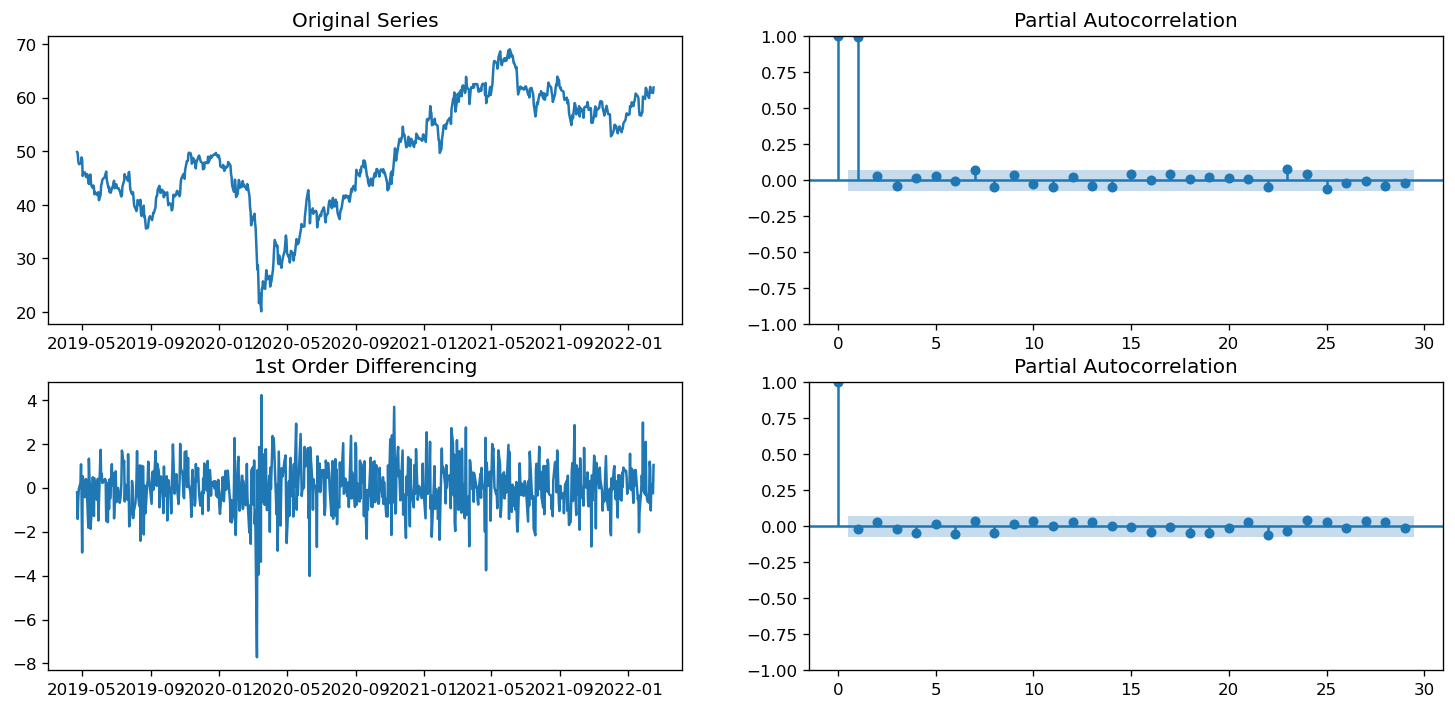

In [ ]:
# Original Series
plt.rcParams.update({'figure.figsize':(15,7)})
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(dow); ax[0, 0].set_title('Original Series')
plot_pacf(dow, ax=ax[0, 1])
ax[0, 1].set_title('Partial Autocorrelation')
# 1st Differencing
ax[1, 0].plot(dow.diff()); ax[1, 0].set_title('1st Order Differencing')
plot_pacf(dow.diff().dropna(), ax=ax[1, 1])
ax[1, 1].set_title('Partial Autocorrelation')


plt.show()

Let's difference.

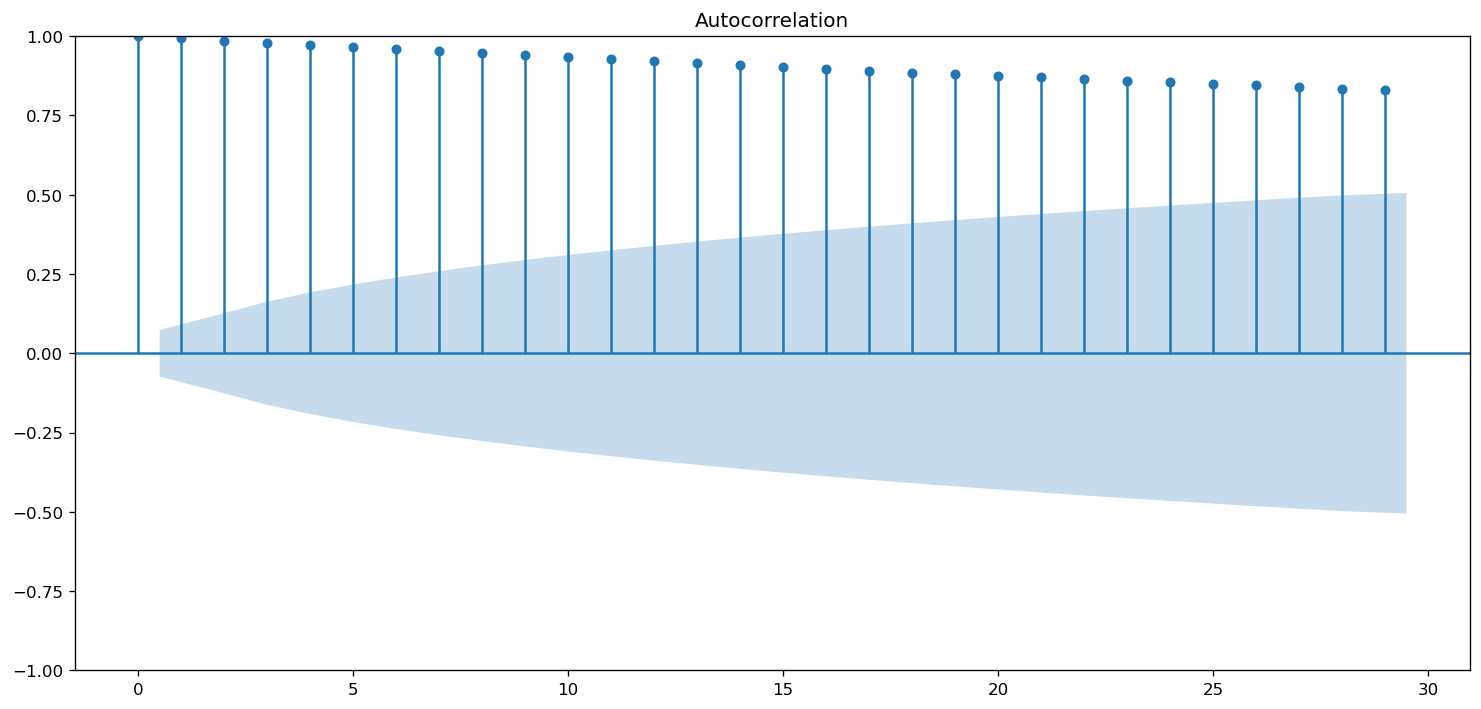

In [ ]:
fig = plot_acf(dow,alpha=0.05) #no noticeable drop to suggest additional MA terms. Choose one

In [ ]:
P=0
D=1
Q=0
# disp = 0
# fit model
N=int(len(dow)*0.7)   
model = sm.tsa.ARIMA(dow.iloc[:N].values, order=(Q,D,P))
model_fit = model.fit()

In [ ]:
fc = model_fit.forecast(steps=len(dow)-N+1, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=range(N-1,len(dow)))

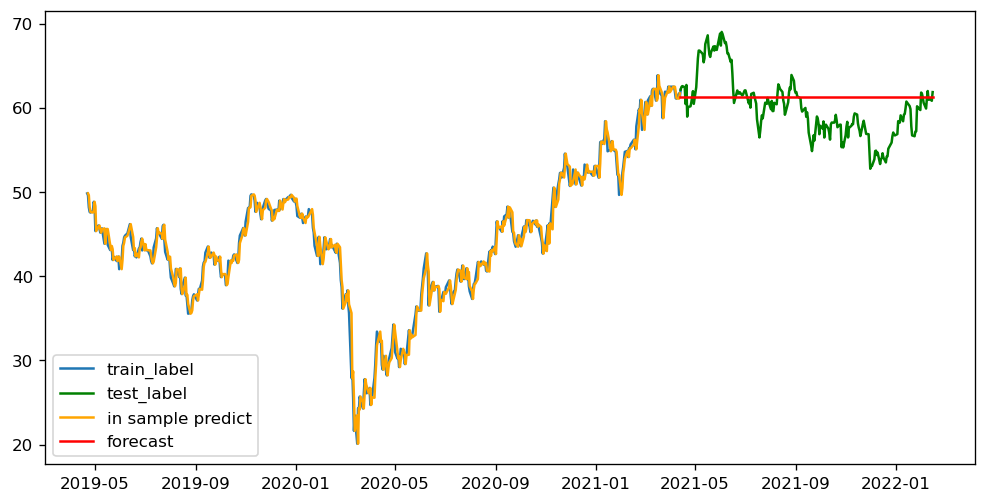

In [ ]:
# Forecast
fc = model_fit.get_forecast(steps=len(dow)-N+1).summary_frame()  # 95% conf
fc_series = pd.Series(fc['mean'])#, index=range(N-1,len(dow)))
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dow.iloc[:N+1],label='train_label')
plt.plot(dow.iloc[N:],color='green',label='test_label')
plt.plot(dow.index[P+D:N+P],model_fit.predict(start=P+D,end=N+P-1,dynamic=False),color='orange',label='in sample predict')
plt.plot(dow.index[N-1:],fc_series, label='forecast', color='red')
plt.legend(loc='lower left')
plt.show();


### Using SARIMA (Sunspots dataset)

![image.png](attachment:image.png)

https://otexts.com/fpp2/seasonal-arima.html

The "S" in SARIMA stands for "seasonal".

A SARIMA model provides the option to apply AR, I, and MA factors to a seasonal period "m".

It's generally better to use the Seasonal AR or MA parts for seasonal effects than to increase the order of the "regular" AR or MA parts of the model.  Likewise, differencing at the Seasonal lag is better to do if a long run dependency is detetected.

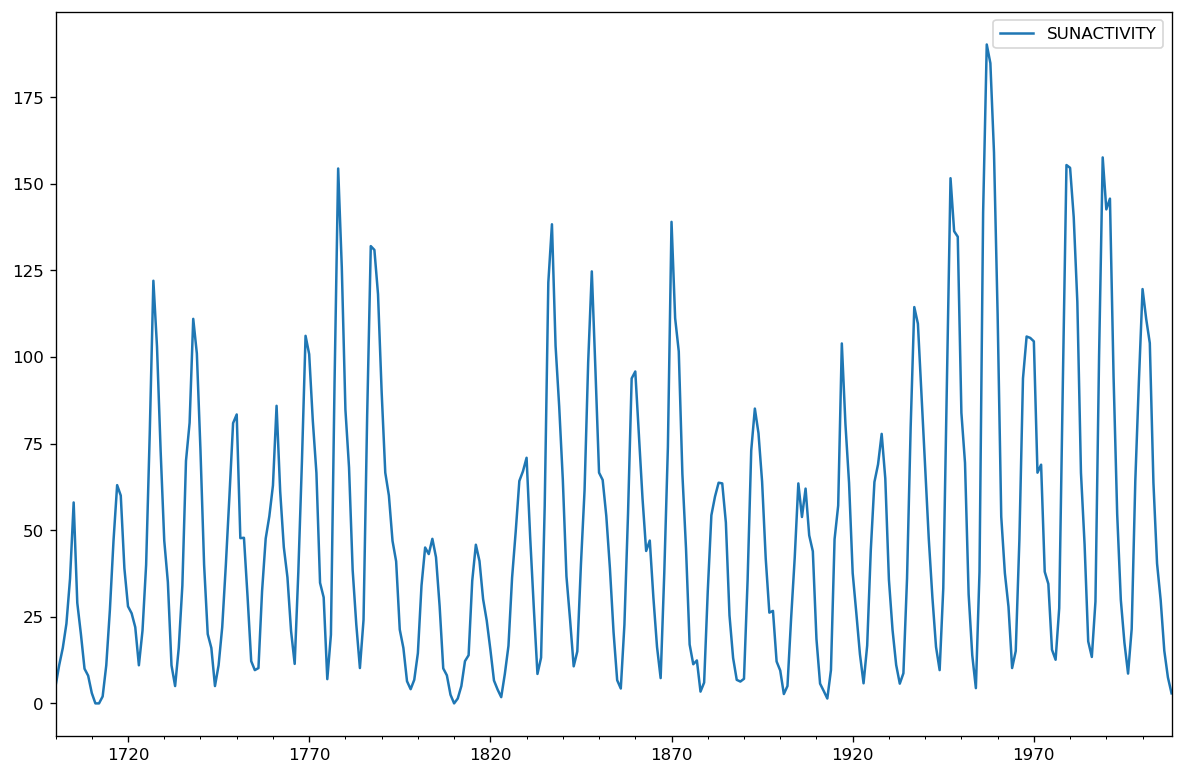

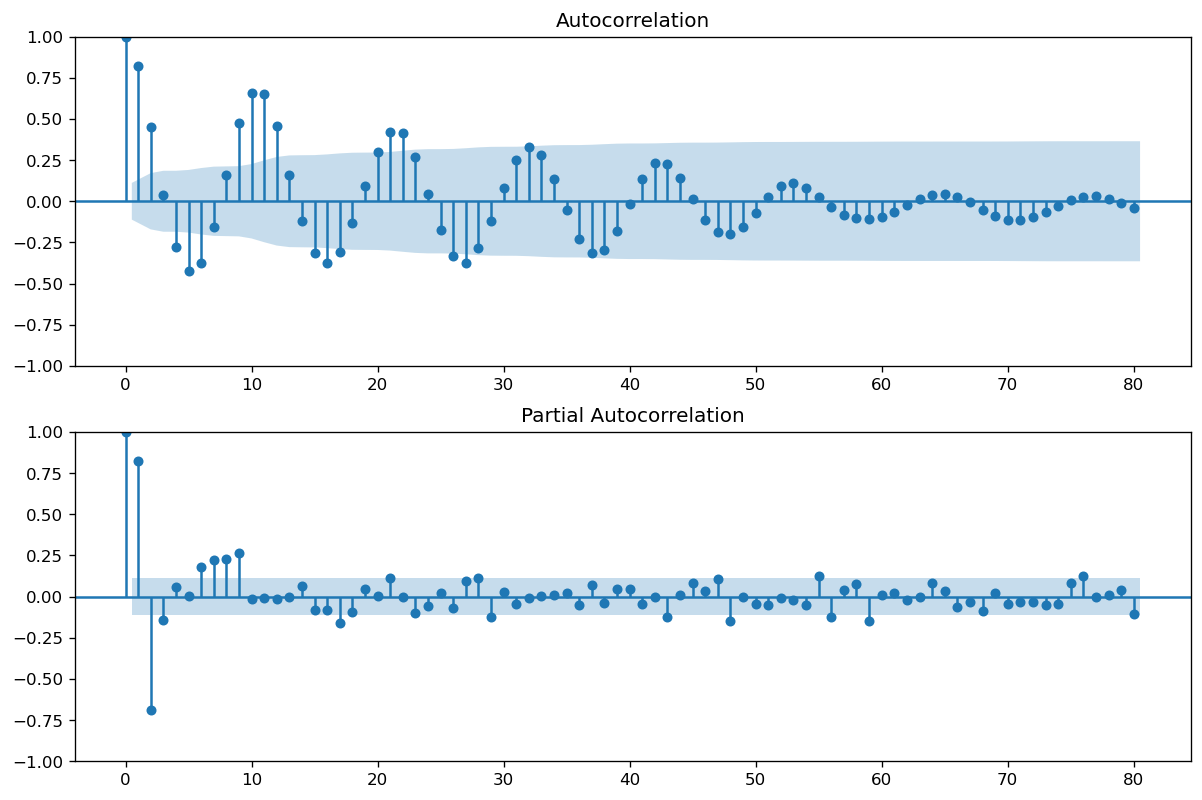

In [ ]:
dta = sm.datasets.sunspots.load_pandas().data
dta
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
dta.plot(figsize=(12,8))
plt.show()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=80, ax=ax2)
plt.show()

In [ ]:
mod = sm.tsa.ARIMA(dta, order=(8, 1, 1),seasonal_order=(0,0,0,11))
model_fit = mod.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                 ARIMA(8, 1, 1)   Log Likelihood               -1273.274
Date:                Tue, 15 Feb 2022   AIC                           2566.547
Time:                        19:37:09   BIC                           2603.848
Sample:                    12-31-1700   HQIC                          2581.462
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2773      0.188      1.477      0.140      -0.091       0.645
ar.L2         -0.2289      0.070     -3.264      0.001      -0.366      -0.091
ar.L3         -0.3490      0.067     -5.175      0.0

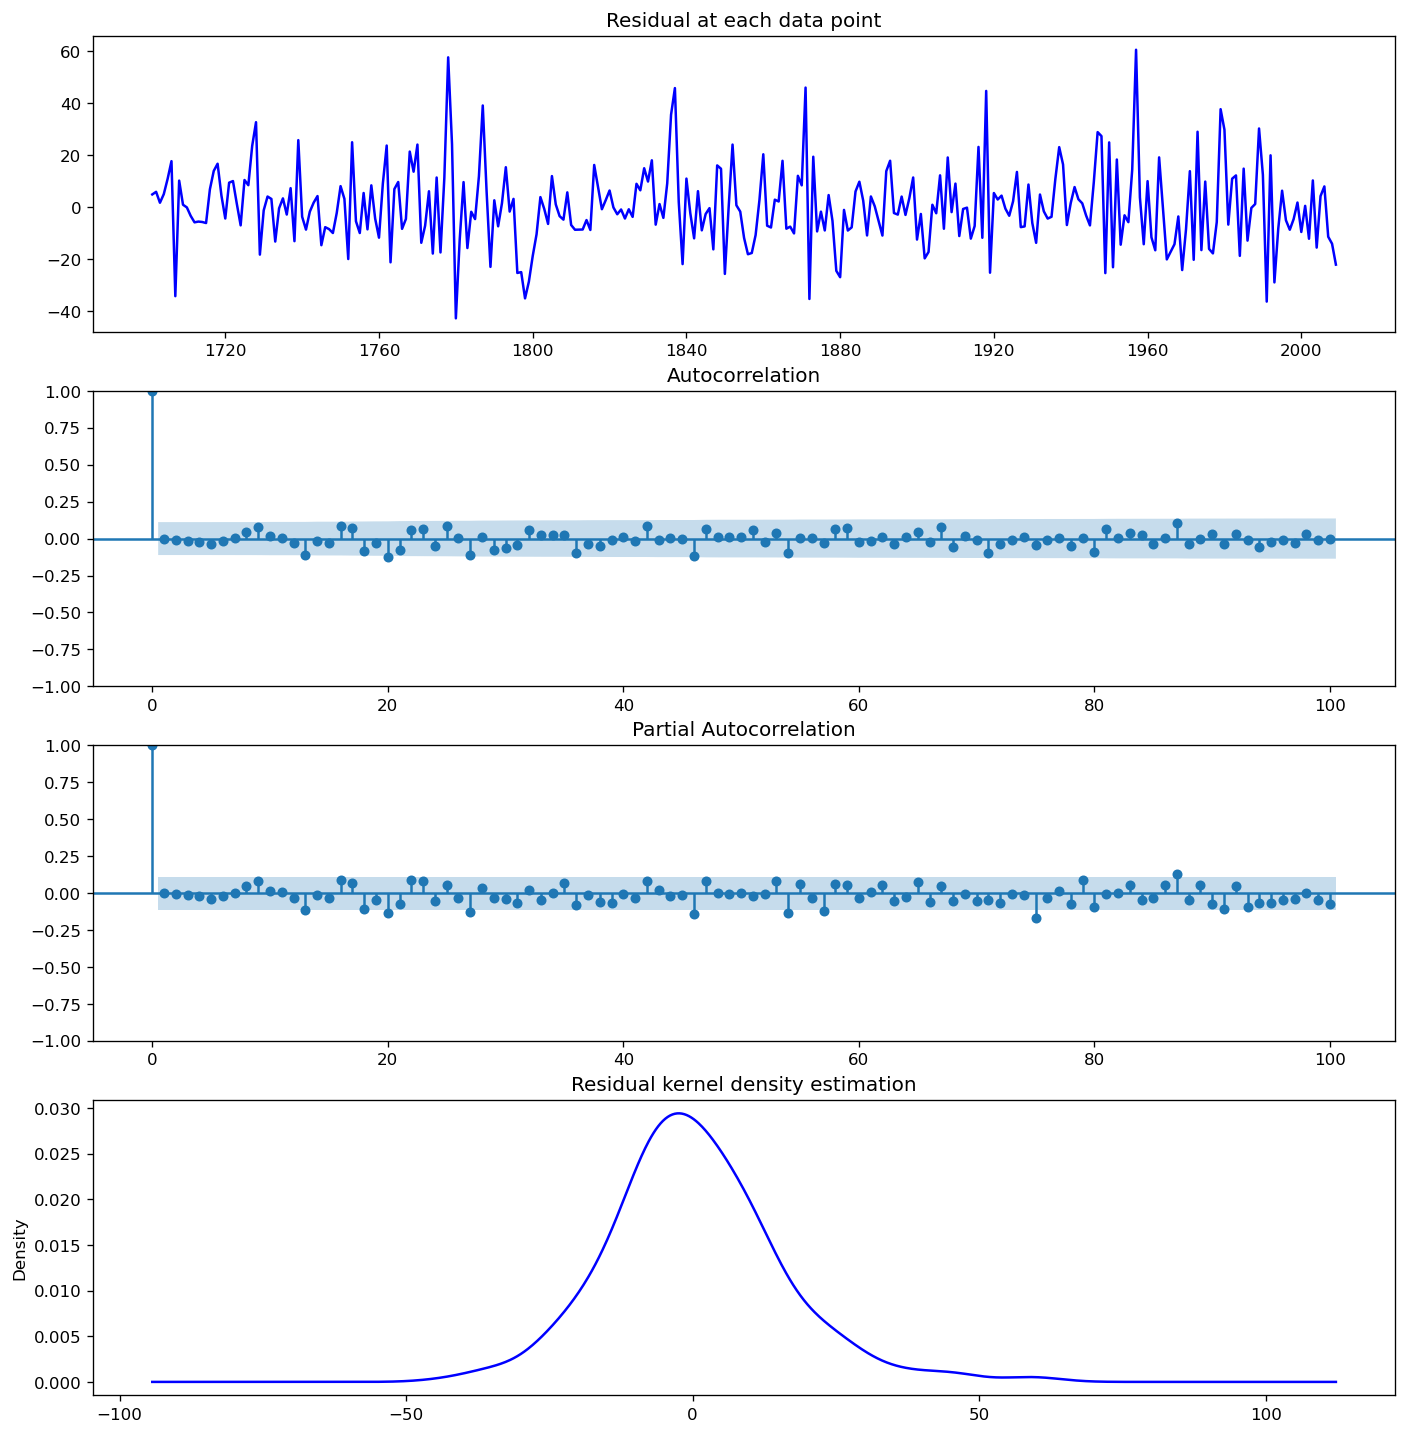

                0
count  309.000000
mean     0.312295
std     15.073736
min    -42.648269
25%     -8.519891
50%     -0.691648
75%      9.090307
max     60.633194
p value is  6.361943155228899e-07
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box (correlations):
     lb_stat  lb_pvalue
1   0.000012   0.997210
2   0.021350   0.989382
3   0.100670   0.991757
4   0.242055   0.993241
5   0.716795   0.982034
6   0.808974   0.991831
7   0.812576   0.997313
8   1.478557   0.993058
9   3.428973   0.944839
10  3.514481   0.966604


In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig = plt.figure(figsize=(14,15))
ax1 = fig.add_subplot(411)
ax1.plot(residuals, 'b')
ax1.set_title('Residual at each data point')
ax2 = fig.add_subplot(412)
fig = sm.graphics.tsa.plot_acf(residuals.values.squeeze(), lags=100, ax=ax2)
ax3 = fig.add_subplot(413)
fig = sm.graphics.tsa.plot_pacf(residuals.values.squeeze(), lags=100, ax=ax3)
ax4 = fig.add_subplot(414)
fig = residuals.plot(kind='kde',ax=ax4,legend=False,color='b')
fig = ax4.set_title('Residual kernel density estimation')
plt.show()

print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box (correlations):")
print(sm.stats.acorr_ljungbox(residuals))

#### ARIMA extensions: "X"

* The "X" extensions ("ARIMAX", "SARIMAX"):   A Linear Regression model with ARIMA errors. ARIMA is used to remove any aurocorrelation in the residuals left over from a regression fit.


#### ARIMA extensions:  "V"

* The "V" extensions ("VAR", "VMA", "VARMAX", "VEC", etc): Generalizations of ARIMA model to multivariate cases. https://otexts.com/fpp2/VAR.html


# Homework 1: Using ARIMA model to predict food_retail capital in Australia.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/australian_capital_retail.csv')
df.head()

,month,cafes_restaurants_and_catering_services,cafes_restaurants_and_takeaway_food_services,clothing_retailing,clothing_footwear_and_personal_accessory_retailing,department_stores,electrical_and_electronic_goods_retailing,food_retailing,footwear_and_other_personal_accessory_retailing,furniture_floor_coverings_houseware_and_textile_goods_retailing,...,household_goods_retailing,liquor_retailing,newspaper_and_book_retailing,other_recreational_goods_retailing,other_retailing,other_retailing_n.e.c.,other_specialised_food_retailing,pharmaceutical_cosmetic_and_toiletry_goods_retailing,supermarket_and_grocery_stores,takeaway_food_services
0,01-04-1982,4.4,7.6,3.7,5.9,10.3,4.4,15.5,2.2,2.7,...,9.7,1.2,2.3,1.1,8.1,2.2,1.6,2.5,12.7,3.2
1,01-05-1982,3.4,6.7,3.8,5.9,10.6,4.9,15.1,2.1,3.0,...,11.1,1.4,2.5,1.0,8.0,2.0,1.6,2.5,12.1,3.3
2,01-06-1982,3.6,7.1,3.2,5.1,9.9,4.8,15.5,2.0,2.5,...,9.9,1.3,2.3,1.0,7.8,2.0,1.7,2.5,12.5,3.5
3,01-07-1982,4.0,7.5,3.4,5.4,8.8,5.1,16.1,2.1,2.8,...,10.2,1.4,2.6,1.1,8.3,2.0,1.6,2.6,13.2,3.5
4,01-08-1982,3.6,7.3,3.1,5.0,8.8,4.6,15.8,2.0,2.8,...,10.1,1.6,2.6,0.9,8.4,2.0,1.6,2.8,12.7,3.7


## Task 1:
#### Aggregate the yearly sum of "food retailing" and visualize it over time.

In [ ]:
df['year'] = pd.DatetimeIndex(df['month']).year
df1 = df[['year', 'food_retailing']]
df1 = df1.groupby('year').sum()
df1.head()

,food_retailing
year,
1982,147.8
1983,218.0
1984,240.6
1985,273.1
1986,303.3


Text(0.5, 0, 'years')

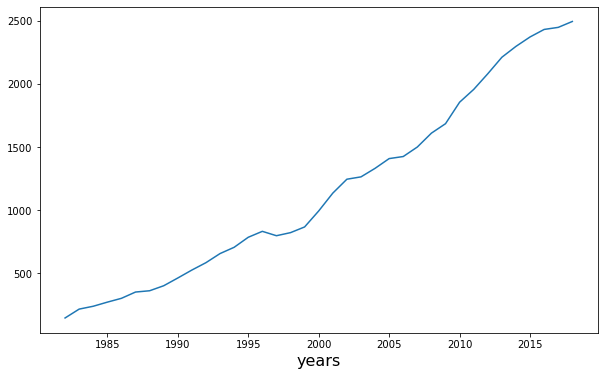

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(df1)
plt.xlabel('years', fontsize=16)

## Task 2:
#### Use the Augmented Dickey–Fuller Test at $\alpha=0.05$ to find out if this timeseries is stationary.  If it is not, use the ARIMA framework to locate a proper order of differencing (d) to reach stationarity. Report the Augmented Dickey–Fuller Test once you've succeded.

In [ ]:
from statsmodels.tsa.stattools import adfuller

series=df1['food_retailing']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.548309
p-value: 0.999064
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623


Dataset is not stationary because the p-value is 0.999, which is much greater than 0.05.

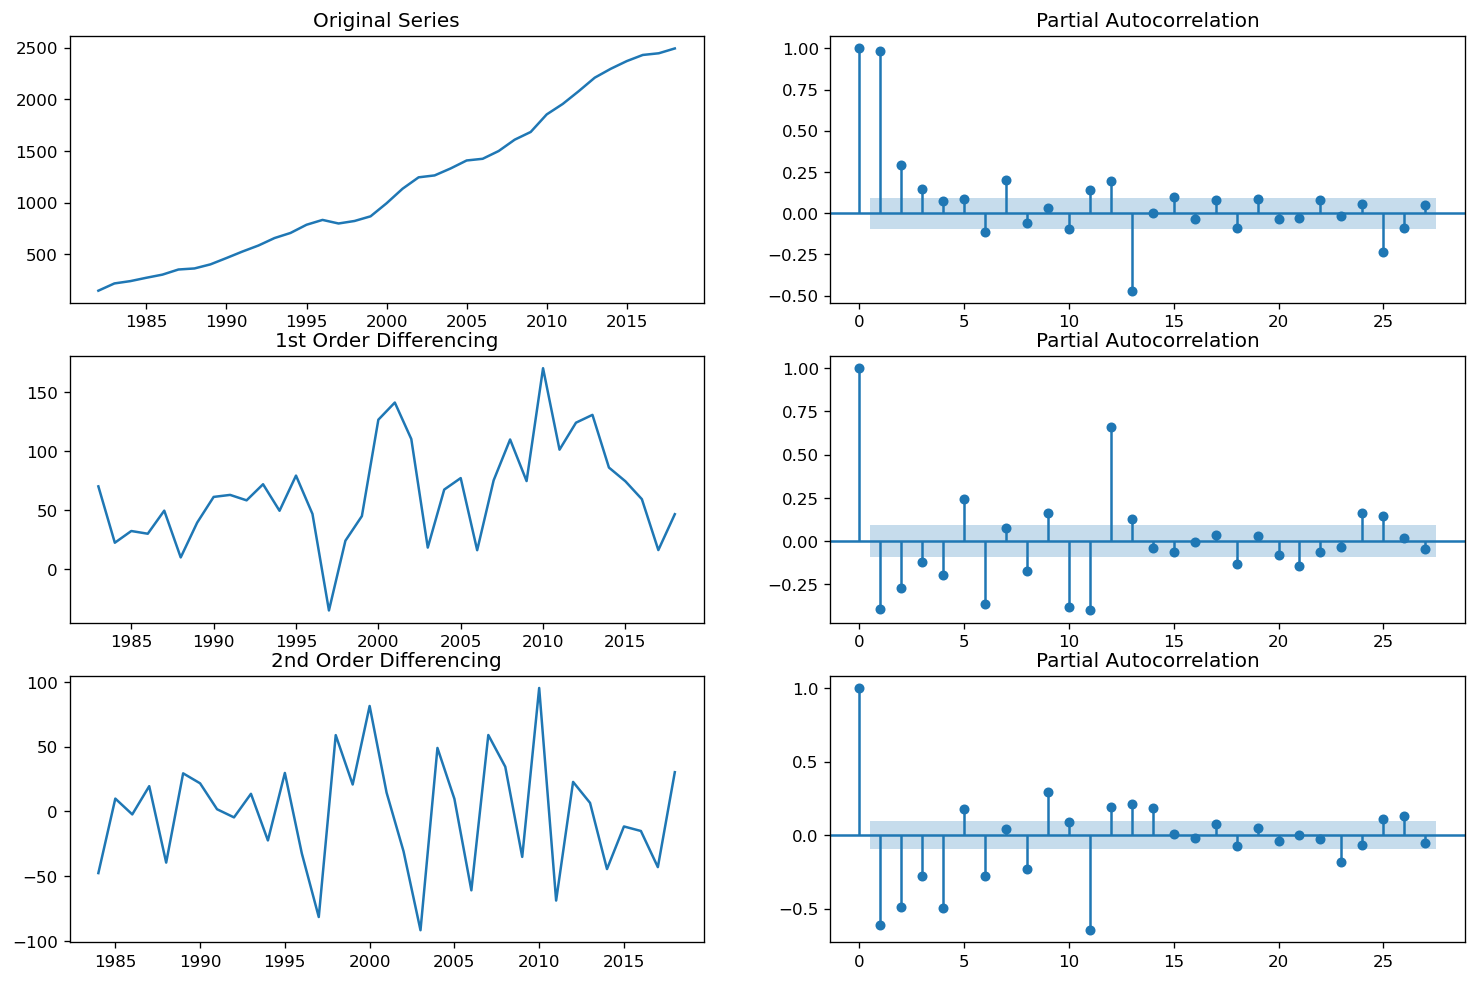

In [ ]:
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df1.food_retailing); axes[0, 0].set_title('Original Series')
plot_pacf(df.food_retailing, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(df1.food_retailing.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df.food_retailing.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(df1.food_retailing.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(df.food_retailing.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')

plt.show()

In [ ]:
series=df1['food_retailing']#.diff()
result = adfuller(series.dropna())
print('raw observations:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])


# first order differencing
series=df1['food_retailing'].diff()
result = adfuller(series.dropna())
print('\n1st order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

# second order differencing
series=df1['food_retailing'].diff().diff()
result = adfuller(series.dropna())
print('\n2nd order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

raw observations:
  ADF Statistic: 2.548309
  p-value: 0.999064

1st order differencing:
  ADF Statistic: -3.444382
  p-value: 0.009536

2nd order differencing:
  ADF Statistic: -2.936616
  p-value: 0.041253


With 0.05, 1st order differencing is enough to be stationary with p-value of 0.009.

## Task 3:
#### Examine the PACF and ACF plots.  What AR and/or MA orders would you choose if any?

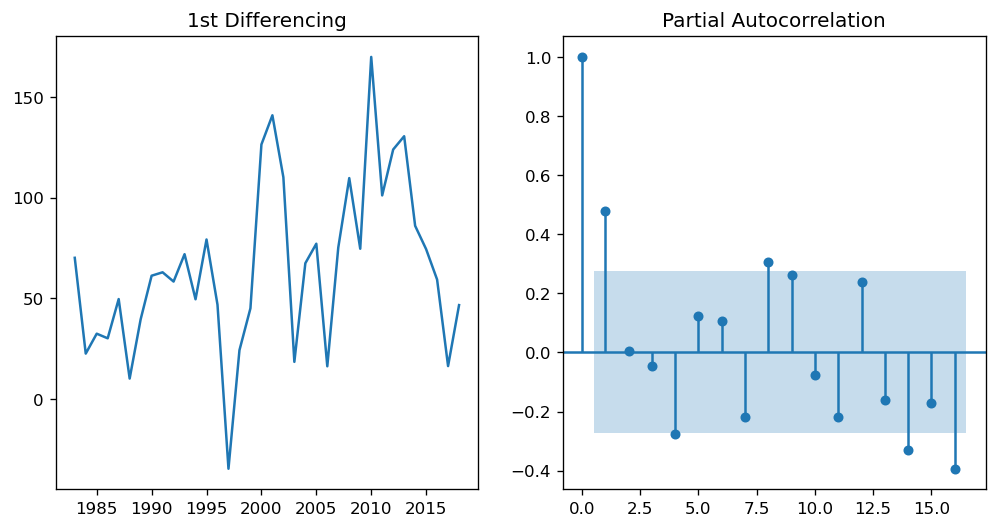

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(df1.food_retailing.diff())
axes[0].set_title('1st Differencing')
# axes[1].set_ylim(0,1)
plot_pacf(df1.food_retailing.diff().dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations

plt.show()

From the partial autocorrelation graph, I can choose Q = 1, because after second, almost every point is with in the blue area. 

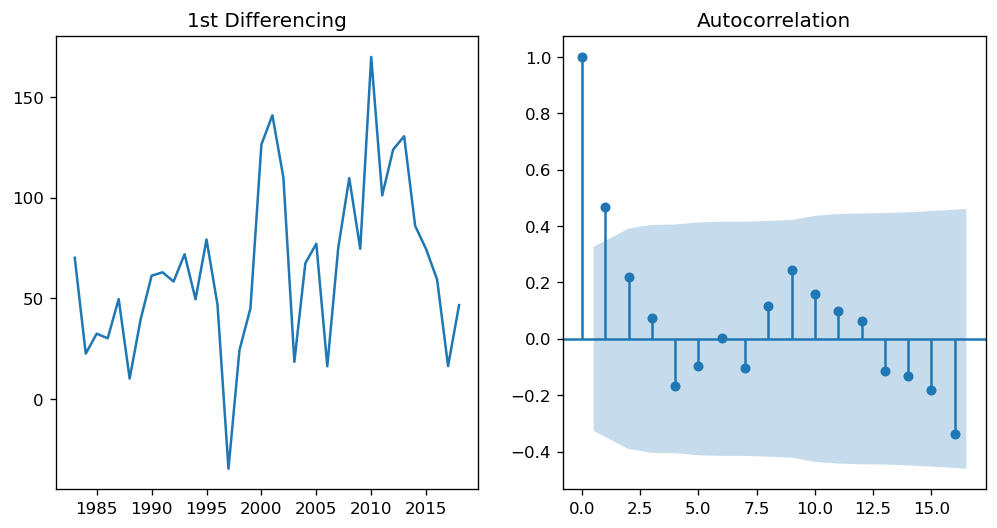

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(df1.food_retailing.diff()); axes[0].set_title('1st Differencing')
plot_acf(df1.food_retailing.diff().dropna(), ax=axes[1])

plt.show()

From the autocorrelation graph, I can choose p = 1, because after 1 every point is with in the blue area

## Task 4:
### Train a model on the first 30 datapoints using an ARIMA(1,1,1) then predict on the last that 30-datapoint training set as well as the last 7 data points. Report and comment on residual diagnostics for both train and test periods, including MAE, RSME, PACF, ACF, a normality test, and a formal autocorrelation test (e.g., Ljung–Box test).

                             ARIMA Model Results                              
Dep. Variable:       D.food_retailing   No. Observations:                   29
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -58.886
Method:                       css-mle   S.D. of innovations              1.744
Date:                Sun, 27 Feb 2022   AIC                            125.771
Time:                        11:34:14   BIC                            131.241
Sample:                             1   HQIC                           127.484
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1944      0.040      4.816      0.000       0.115       0.274
ar.L1.D.food_retailing     0.0965      0.189      0.512      0.609      -0.273       0.466
ma.L

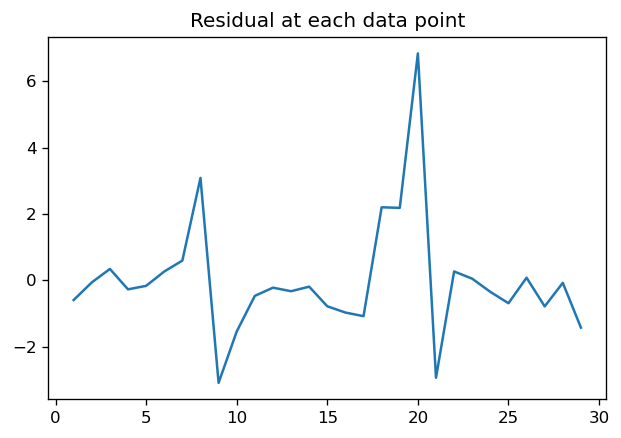

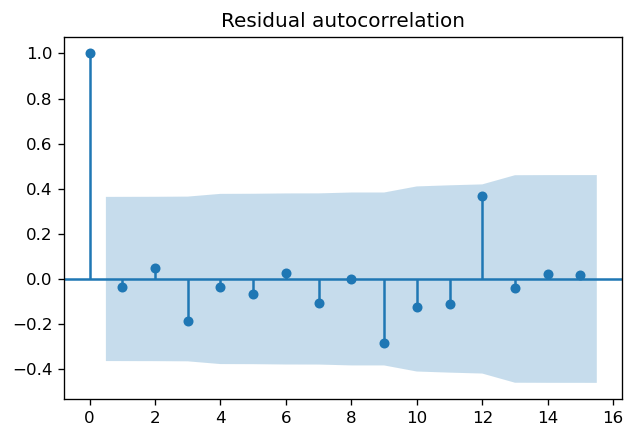

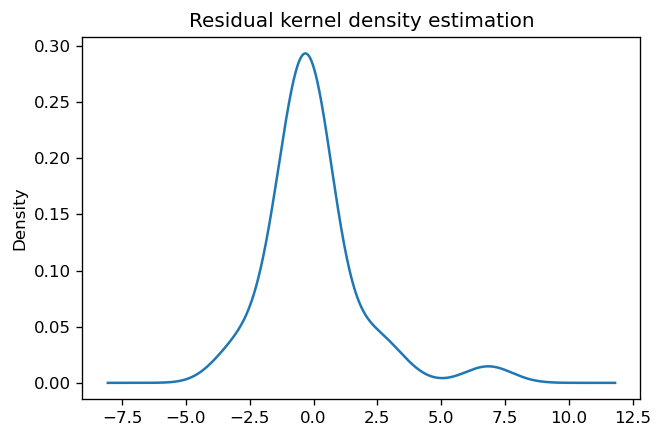

               0
count  29.000000
mean   -0.004680
std     1.832602
min    -3.092318
25%    -0.783341
50%    -0.222044
75%     0.264995
max     6.842164
p value is  3.7341584094409026e-06
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
(array([ 0.03613679,  0.10983044,  1.28695732,  1.33444529,  1.49014199,
        1.5167265 ,  1.9705539 ,  1.9706483 ,  5.60610708,  6.33260194,
        6.97222937, 14.11468538]), array([0.84923329, 0.94656539, 0.7322325 , 0.85550487, 0.91420461,
       0.95837574, 0.96145213, 0.98189849, 0.7786011 , 0.78658841,
       0.80132794, 0.29344473]))


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

P=1
D=1
Q=1

# fit model
N=30   
series = df['food_retailing']#.values

#model = sm.tsa.SARIMAX(series[:N], order=(Q,D,P))
model = sm.tsa.ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

In [ ]:
fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(df.index[:N+1],series[:N+1],label='train_label') # train
ax.plot(df.index[N:],series[N:],color='green',label='test_label') # test
ax.plot(df.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(df.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')

AttributeError: 'ARIMAResults' object has no attribute 'get_forecast'

# Homework 2: Using ARIMA model to predict a one-direction random walk.


## Task 1:
### Generate a one-dimensional additive random walk that starts at 0, with subsequent up/down steps at equal probability. Simulate 1000 steps and visualize the result.  Use random seed 1234.

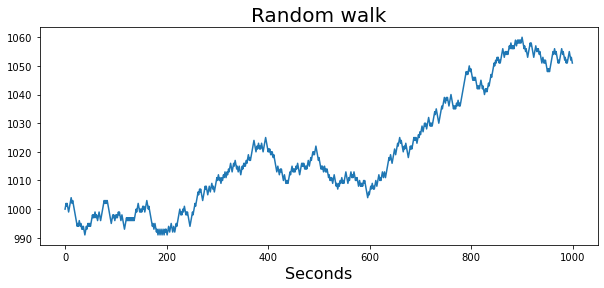

In [ ]:
from matplotlib.pyplot import figure
np.random.seed(1234)

pos = 1000  
walk = [pos] # walk is the array that tracks the random path
nsteps = 1000 # establishs number of random steps
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 # Bernoulli draw to step "up" or "down"
    pos += step
    walk.append(pos)

figure(figsize = (10,4))
plt.plot(walk[0:1000])
plt.title('Random walk', fontsize=20)
plt.xlabel('Seconds', fontsize=16)
plt.show();

## Task 2:
### Make the series stationary.  Report results from Augmented Dickey–Fuller Test at $\alpha=0.05$.

In [ ]:
series=walk
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.350132
p-value: 0.918098
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [ ]:
df2 = pd.DataFrame(walk)
df2.head()

,0
0,1000
1,1001
2,1002
3,1001
4,1002


In [ ]:
series=df2#.diff()
result = adfuller(series.dropna())
print('raw observations:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])


# first order differencing
series=df2.diff()
result = adfuller(series.dropna())
print('\n1st order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])


raw observations:
  ADF Statistic: -0.350132
  p-value: 0.918098

1st order differencing:
  ADF Statistic: -31.746941
  p-value: 0.000000


After the first order differencing, the data become staionary, and the p-value is 0 which is smaller than 0.05

## Task 3:
### Difference the series and plot their PACF and ACFs.  What do you notice?

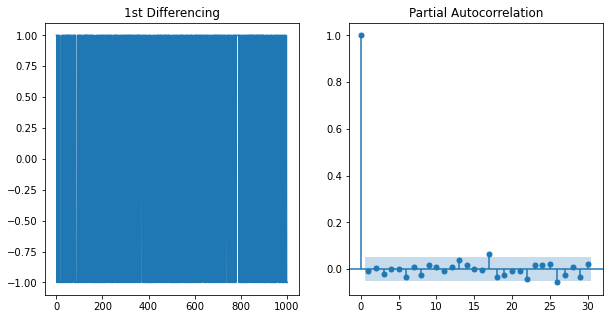

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(df2.diff())
axes[0].set_title('1st Differencing')
# axes[1].set_ylim(0,1)
plot_pacf(df2.diff().dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations

plt.show()

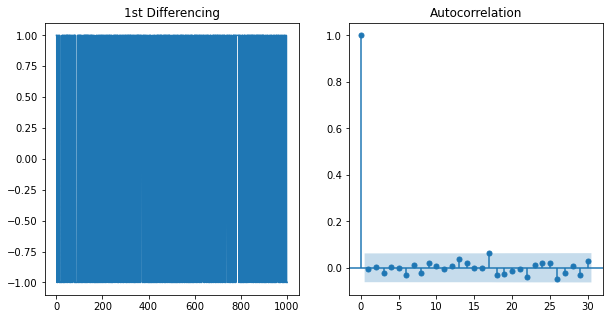

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(df2.diff()); axes[0].set_title('1st Differencing')
plot_acf(df2.diff().dropna(), ax=axes[1])

plt.show()

I notice after first order differencing, the data become completely random and it should be white noise. 